In [2]:
#import lightgbm
import random
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor
import time
from sklearn.metrics import make_scorer
t = time.strftime('%m%d-%H%M', time.localtime(time.time()))
import warnings
warnings.filterwarnings(action='ignore')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정
#### alpha를 argument로 받는 함수로 실제 objective function을 wrapping하여 alpha값을 쉽게 조정할 수 있도록 작성했습니다.
# custom objective function for forcing model not to underestimate
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

 #점수 측정을 위한 코드
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

깊이 튜닝

In [2]:
hyperparameters = pd.DataFrame(columns = ['n_estimators', 'eta', 'min_child_weight','max_depth', 'colsample_bytree', 'subsample'])
preds = np.array([])

grid = {'n_estimators' : [100], 'eta' : [0.01], 'min_child_weight' : np.arange(1, 12, 1),
        'max_depth' : np.arange(3,10,1) , 'colsample_bytree' :[0.8, 0.9],
        'subsample' : [0.8, 0.9]} # fix the n_estimators & eta(learning rate)

#tscv = TimeSeriesSplit(n_splits=3)
smape_score = make_scorer(SMAPE, greater_is_better=False)

for i in tqdm(np.arange(1, 101, 1)):
    train_df = pd.read_csv(f'./pretest/train_building{i}.csv').drop(columns=['Unnamed: 0'])
    pretest_df = pd.read_csv(f'./pretest/pretest_building{i}.csv').drop(columns=['Unnamed: 0'])
    ################################################
    #merge = pd.concat([train_df,pretest_df])
    ################################################
    #하이퍼 파라미터 튜닝 method 1
    #leaf method
    print(f"__________Buildding Number:{i} Hyperparameter Tuning__________")

    preds = np.array([])
    smape_score = make_scorer(SMAPE, greater_is_better=False)
    grid = {'n_estimators' : [100], 'eta' : [0.01], 'min_child_weight' : np.arange(1, 12, 1), 'max_depth' : np.arange(3,10,1) , 'colsample_bytree' :[0.8, 0.9], 'subsample' : [0.8, 0.9]} 
    grid_under = {}
    #합병된 데이터 사용
    y = train_df['power_consumption']
    x = train_df.drop(columns=['power_consumption'])
    #y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)
    #fit
    gcv = GridSearchCV(estimator = XGBRegressor(seed=0,tree_method="hist", gpu_id=0), param_grid=grid, scoring=smape_score, cv=PredefinedSplit(np.append(-np.ones(len(x)-168), np.zeros(168))) ,refit=True, verbose=False)
    gcv.fit(x, y)

    best = gcv.best_estimator_
    params = gcv.best_params_

    #pred
    x_pretest = pretest_df.drop(columns=['power_consumption'])
    y_pretest = pretest_df['power_consumption']
    pred = best.predict(x_pretest)
    print("_____Best Parameters_____",params)
    print("_____SMAPE Score________", SMAPE(y_pretest, pred))
    hyperparameters = pd.concat([hyperparameters,pd.DataFrame(params,index=[i-1])],axis=0)
hyperparameters.to_csv(f'./parameters/hyperparameter_xgb_wsw{t}.csv', index=False) # save the tuned parameters


  0%|          | 0/100 [00:00<?, ?it/s]

__________Buildding Number:1 Hyperparameter Tuning__________


  1%|          | 1/100 [00:21<34:39, 21.01s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.63810992906832
__________Buildding Number:2 Hyperparameter Tuning__________


  2%|▏         | 2/100 [00:42<35:08, 21.52s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 40.75441260842513
__________Buildding Number:3 Hyperparameter Tuning__________


  3%|▎         | 3/100 [01:06<36:33, 22.61s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 35.72841986223163
__________Buildding Number:4 Hyperparameter Tuning__________


  4%|▍         | 4/100 [01:25<33:59, 21.25s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 42.498150524143085
__________Buildding Number:5 Hyperparameter Tuning__________


  5%|▌         | 5/100 [01:47<33:55, 21.43s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 47.13408518643146
__________Buildding Number:6 Hyperparameter Tuning__________


  6%|▌         | 6/100 [02:07<32:38, 20.84s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.97467266597254
__________Buildding Number:7 Hyperparameter Tuning__________


  7%|▋         | 7/100 [02:28<32:31, 20.99s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 41.23418971613774
__________Buildding Number:8 Hyperparameter Tuning__________


  8%|▊         | 8/100 [02:47<30:53, 20.15s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 45.097564781433164
__________Buildding Number:9 Hyperparameter Tuning__________


  9%|▉         | 9/100 [03:07<30:46, 20.29s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.90548247374474
__________Buildding Number:10 Hyperparameter Tuning__________


 10%|█         | 10/100 [03:27<30:15, 20.17s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 37.779634850935345
__________Buildding Number:11 Hyperparameter Tuning__________


 11%|█         | 11/100 [03:43<28:11, 19.01s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 43.10168583630656
__________Buildding Number:12 Hyperparameter Tuning__________


 12%|█▏        | 12/100 [04:00<26:59, 18.40s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.72565069370894
__________Buildding Number:13 Hyperparameter Tuning__________


 13%|█▎        | 13/100 [04:19<26:38, 18.38s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.34648288076374
__________Buildding Number:14 Hyperparameter Tuning__________


 14%|█▍        | 14/100 [04:41<28:03, 19.58s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 39.39560776873195
__________Buildding Number:15 Hyperparameter Tuning__________


 15%|█▌        | 15/100 [05:00<27:23, 19.33s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 42.120243428365285
__________Buildding Number:16 Hyperparameter Tuning__________


 16%|█▌        | 16/100 [05:20<27:26, 19.60s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 42.091455957066835
__________Buildding Number:17 Hyperparameter Tuning__________


 17%|█▋        | 17/100 [05:37<26:09, 18.92s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 47.31299412313642
__________Buildding Number:18 Hyperparameter Tuning__________


 18%|█▊        | 18/100 [05:58<26:25, 19.33s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 48.82394255770483
__________Buildding Number:19 Hyperparameter Tuning__________


 19%|█▉        | 19/100 [06:18<26:37, 19.72s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 49.38934606463118
__________Buildding Number:20 Hyperparameter Tuning__________


 20%|██        | 20/100 [06:40<26:57, 20.22s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.43470752950029
__________Buildding Number:21 Hyperparameter Tuning__________


 21%|██        | 21/100 [07:01<27:02, 20.54s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.851893972736356
__________Buildding Number:22 Hyperparameter Tuning__________


 22%|██▏       | 22/100 [07:20<26:08, 20.10s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 45.5948627010755
__________Buildding Number:23 Hyperparameter Tuning__________


 23%|██▎       | 23/100 [07:38<25:07, 19.57s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.411540896725874
__________Buildding Number:24 Hyperparameter Tuning__________


 24%|██▍       | 24/100 [07:58<24:42, 19.50s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 44.528434325640326
__________Buildding Number:25 Hyperparameter Tuning__________


 25%|██▌       | 25/100 [08:16<23:54, 19.12s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 47.1803722603669
__________Buildding Number:26 Hyperparameter Tuning__________


 26%|██▌       | 26/100 [08:36<23:55, 19.40s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.92423865315791
__________Buildding Number:27 Hyperparameter Tuning__________


 27%|██▋       | 27/100 [08:55<23:20, 19.19s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 43.12685075840029
__________Buildding Number:28 Hyperparameter Tuning__________


 28%|██▊       | 28/100 [09:14<23:10, 19.31s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 39.10198060387352
__________Buildding Number:29 Hyperparameter Tuning__________


 29%|██▉       | 29/100 [09:35<23:27, 19.83s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 42.589556179661905
__________Buildding Number:30 Hyperparameter Tuning__________


 30%|███       | 30/100 [09:58<24:14, 20.78s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 43.69287550548363
__________Buildding Number:31 Hyperparameter Tuning__________


 31%|███       | 31/100 [10:18<23:30, 20.45s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 40.43054573157011
__________Buildding Number:32 Hyperparameter Tuning__________


 32%|███▏      | 32/100 [10:32<20:54, 18.45s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.44472880625884
__________Buildding Number:33 Hyperparameter Tuning__________


 33%|███▎      | 33/100 [10:46<19:01, 17.04s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.056957194674006
__________Buildding Number:34 Hyperparameter Tuning__________


 34%|███▍      | 34/100 [11:00<17:47, 16.18s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 44.58383411174869
__________Buildding Number:35 Hyperparameter Tuning__________


 35%|███▌      | 35/100 [11:13<16:40, 15.39s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.98969193139706
__________Buildding Number:36 Hyperparameter Tuning__________


 36%|███▌      | 36/100 [11:26<15:33, 14.59s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.98080167039337
__________Buildding Number:37 Hyperparameter Tuning__________


 37%|███▋      | 37/100 [11:46<17:09, 16.34s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 47.332622956311276
__________Buildding Number:38 Hyperparameter Tuning__________


 38%|███▊      | 38/100 [12:08<18:32, 17.94s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 9, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.739593718605
__________Buildding Number:39 Hyperparameter Tuning__________


 39%|███▉      | 39/100 [12:29<19:07, 18.81s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 47.97299387618539
__________Buildding Number:40 Hyperparameter Tuning__________


 40%|████      | 40/100 [12:53<20:14, 20.24s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.63079896291825
__________Buildding Number:41 Hyperparameter Tuning__________


 41%|████      | 41/100 [13:14<20:17, 20.63s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.099721885536
__________Buildding Number:42 Hyperparameter Tuning__________


 42%|████▏     | 42/100 [13:36<20:26, 21.14s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 47.27635500557693
__________Buildding Number:43 Hyperparameter Tuning__________


 43%|████▎     | 43/100 [13:58<20:12, 21.28s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.54117704296544
__________Buildding Number:44 Hyperparameter Tuning__________


 44%|████▍     | 44/100 [14:20<19:57, 21.38s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 42.74927453035661
__________Buildding Number:45 Hyperparameter Tuning__________


 45%|████▌     | 45/100 [14:40<19:12, 20.96s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.89341041322503
__________Buildding Number:46 Hyperparameter Tuning__________


 46%|████▌     | 46/100 [15:00<18:48, 20.89s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.615806583877806
__________Buildding Number:47 Hyperparameter Tuning__________


 47%|████▋     | 47/100 [15:20<18:14, 20.66s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 42.088335517241354
__________Buildding Number:48 Hyperparameter Tuning__________


 48%|████▊     | 48/100 [15:41<17:45, 20.49s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.94964548186855
__________Buildding Number:49 Hyperparameter Tuning__________


 49%|████▉     | 49/100 [16:00<17:03, 20.07s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 48.05654903632217
__________Buildding Number:50 Hyperparameter Tuning__________


 50%|█████     | 50/100 [16:19<16:27, 19.75s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 43.64226354048831
__________Buildding Number:51 Hyperparameter Tuning__________


 51%|█████     | 51/100 [16:39<16:09, 19.80s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.79406845819842
__________Buildding Number:52 Hyperparameter Tuning__________


 52%|█████▏    | 52/100 [16:59<15:56, 19.92s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.63003329505508
__________Buildding Number:53 Hyperparameter Tuning__________


 53%|█████▎    | 53/100 [17:23<16:35, 21.18s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 38.209693577371326
__________Buildding Number:54 Hyperparameter Tuning__________


 54%|█████▍    | 54/100 [17:48<17:11, 22.41s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 58.40731632362052
__________Buildding Number:55 Hyperparameter Tuning__________


 55%|█████▌    | 55/100 [18:05<15:30, 20.67s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.20905083511754
__________Buildding Number:56 Hyperparameter Tuning__________


 56%|█████▌    | 56/100 [18:21<14:10, 19.34s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.50313502118374
__________Buildding Number:57 Hyperparameter Tuning__________


 57%|█████▋    | 57/100 [18:42<14:18, 19.97s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.89359973226942
__________Buildding Number:58 Hyperparameter Tuning__________


 58%|█████▊    | 58/100 [18:57<12:54, 18.44s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.51838899832923
__________Buildding Number:59 Hyperparameter Tuning__________


 59%|█████▉    | 59/100 [19:19<13:20, 19.52s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 43.31240791183803
__________Buildding Number:60 Hyperparameter Tuning__________


 60%|██████    | 60/100 [19:40<13:13, 19.84s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.296886833195266
__________Buildding Number:61 Hyperparameter Tuning__________


 61%|██████    | 61/100 [20:02<13:18, 20.48s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 43.565683148863364
__________Buildding Number:62 Hyperparameter Tuning__________


 62%|██████▏   | 62/100 [20:24<13:14, 20.91s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 41.99114089743699
__________Buildding Number:63 Hyperparameter Tuning__________


 63%|██████▎   | 63/100 [20:46<13:12, 21.43s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 42.0660122436718
__________Buildding Number:64 Hyperparameter Tuning__________


 64%|██████▍   | 64/100 [21:09<12:59, 21.66s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 42.847135326018766
__________Buildding Number:65 Hyperparameter Tuning__________


 65%|██████▌   | 65/100 [21:33<13:05, 22.44s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 38.12679158875055
__________Buildding Number:66 Hyperparameter Tuning__________


 66%|██████▌   | 66/100 [21:54<12:25, 21.93s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.561339934164195
__________Buildding Number:67 Hyperparameter Tuning__________


 67%|██████▋   | 67/100 [22:16<12:06, 22.03s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 36.07296291821004
__________Buildding Number:68 Hyperparameter Tuning__________


 68%|██████▊   | 68/100 [22:39<11:51, 22.25s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 41.83252481905676
__________Buildding Number:69 Hyperparameter Tuning__________


 69%|██████▉   | 69/100 [22:59<11:09, 21.60s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 43.72996776603075
__________Buildding Number:70 Hyperparameter Tuning__________


 70%|███████   | 70/100 [23:21<10:52, 21.77s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 46.67417488065432
__________Buildding Number:71 Hyperparameter Tuning__________


 71%|███████   | 71/100 [23:42<10:22, 21.48s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.86220198904975
__________Buildding Number:72 Hyperparameter Tuning__________


 72%|███████▏  | 72/100 [24:00<09:36, 20.60s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 47.06090121470123
__________Buildding Number:73 Hyperparameter Tuning__________


 73%|███████▎  | 73/100 [24:19<09:01, 20.07s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.201603451110834
__________Buildding Number:74 Hyperparameter Tuning__________


 74%|███████▍  | 74/100 [24:41<08:53, 20.52s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 47.16257094218247
__________Buildding Number:75 Hyperparameter Tuning__________


 75%|███████▌  | 75/100 [25:03<08:47, 21.09s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.598246643248494
__________Buildding Number:76 Hyperparameter Tuning__________


 76%|███████▌  | 76/100 [25:23<08:19, 20.80s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.237623164945006
__________Buildding Number:77 Hyperparameter Tuning__________


 77%|███████▋  | 77/100 [25:44<07:59, 20.83s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.72760178206778
__________Buildding Number:78 Hyperparameter Tuning__________


 78%|███████▊  | 78/100 [26:05<07:39, 20.88s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 47.89101991469375
__________Buildding Number:79 Hyperparameter Tuning__________


 79%|███████▉  | 79/100 [26:26<07:16, 20.81s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 46.03871162343122
__________Buildding Number:80 Hyperparameter Tuning__________


 80%|████████  | 80/100 [26:47<07:01, 21.07s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 47.03816510715506
__________Buildding Number:81 Hyperparameter Tuning__________


 81%|████████  | 81/100 [27:09<06:41, 21.13s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.704577011001234
__________Buildding Number:82 Hyperparameter Tuning__________


 82%|████████▏ | 82/100 [27:31<06:24, 21.38s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 44.23291336843806
__________Buildding Number:83 Hyperparameter Tuning__________


 83%|████████▎ | 83/100 [27:52<06:01, 21.27s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 46.01690560791188
__________Buildding Number:84 Hyperparameter Tuning__________


 84%|████████▍ | 84/100 [28:13<05:38, 21.15s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 44.907297573643504
__________Buildding Number:85 Hyperparameter Tuning__________


 85%|████████▌ | 85/100 [28:31<05:06, 20.40s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 47.16626744469539
__________Buildding Number:86 Hyperparameter Tuning__________


 86%|████████▌ | 86/100 [28:54<04:54, 21.02s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 47.75271064974007
__________Buildding Number:87 Hyperparameter Tuning__________


 87%|████████▋ | 87/100 [29:18<04:46, 22.07s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.33434946432375
__________Buildding Number:88 Hyperparameter Tuning__________


 88%|████████▊ | 88/100 [29:41<04:26, 22.23s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 49.35939926417297
__________Buildding Number:89 Hyperparameter Tuning__________


 89%|████████▉ | 89/100 [30:04<04:06, 22.40s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 49.01055050062033
__________Buildding Number:90 Hyperparameter Tuning__________


 90%|█████████ | 90/100 [30:27<03:45, 22.55s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 50.59131377193681
__________Buildding Number:91 Hyperparameter Tuning__________


 91%|█████████ | 91/100 [30:48<03:19, 22.17s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 48.31484673373296
__________Buildding Number:92 Hyperparameter Tuning__________


 92%|█████████▏| 92/100 [31:08<02:53, 21.63s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.05154649933349
__________Buildding Number:93 Hyperparameter Tuning__________


 93%|█████████▎| 93/100 [31:28<02:27, 21.09s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 43.25009537474799
__________Buildding Number:94 Hyperparameter Tuning__________


 94%|█████████▍| 94/100 [31:49<02:05, 20.97s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.10354842419911
__________Buildding Number:95 Hyperparameter Tuning__________


 95%|█████████▌| 95/100 [32:10<01:45, 21.12s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 30.746591920082988
__________Buildding Number:96 Hyperparameter Tuning__________


 96%|█████████▌| 96/100 [32:30<01:22, 20.65s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 41.11370680782174
__________Buildding Number:97 Hyperparameter Tuning__________


 97%|█████████▋| 97/100 [32:50<01:01, 20.55s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 48.033687784036296
__________Buildding Number:98 Hyperparameter Tuning__________


 98%|█████████▊| 98/100 [33:12<00:41, 20.98s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 36.643630675244985
__________Buildding Number:99 Hyperparameter Tuning__________


 99%|█████████▉| 99/100 [33:32<00:20, 20.80s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.22650307078898
__________Buildding Number:100 Hyperparameter Tuning__________


100%|██████████| 100/100 [33:54<00:00, 20.34s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 47.24331133279432


n_estimators 튜닝

In [4]:
#n_estimators
xgb_params = pd.read_csv(f'./parameters/hyperparameter_xgb_wsw{t}.csv')
scores = []   # smape 값을 저장할 list
best_it = []  # best interation을 저장할 list
for i in tqdm(range(100)):
    train_df = pd.read_csv(f'./pretest/train_building{i+1}.csv').drop(columns=['Unnamed: 0'])
    pretest_df = pd.read_csv(f'./pretest/pretest_building{i+1}.csv').drop(columns=['Unnamed: 0'])
    ################################################
    t_y = train_df['power_consumption']
    t_x = train_df.drop(['power_consumption'], axis=1)
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = t_y, X = t_x, test_size = 168)
    
    p_y = pretest_df['power_consumption']
    p_x = pretest_df.drop(['power_consumption'], axis=1)

    xgb_reg = XGBRegressor(n_estimators = 10000, tree_method="hist",  gpu_id=0, 
                           eta = 0.01, 
                           min_child_weight = xgb_params.iloc[i, 2],
                           max_depth = xgb_params.iloc[i, 3], 
                           colsample_bytree = xgb_params.iloc[i, 4],
                           subsample = xgb_params.iloc[i, 5], 
                           seed=0)
    xgb_reg.set_params(**{'objective':weighted_mse(100)}) # alpha = 100으로 고정

    xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train),(x_valid, y_valid)], early_stopping_rounds=300, verbose=False)
    
    y_pred = xgb_reg.predict(p_x)
    pred = pd.Series(y_pred)
    
    sm = SMAPE(p_y, y_pred)
    scores.append(sm)
    best_it.append(xgb_reg.best_iteration+1) ## 실제 best iteration은 이 값에 +1 해주어야 함.
hyperparameters['best_it'] = best_it

100%|██████████| 100/100 [02:09<00:00,  1.30s/it]


alpha튜닝

In [5]:
xgb_params = pd.read_csv(f'./parameters/hyperparameter_xgb_wsw{t}.csv')
#alpha
alpha_list = []
smape_list = []
for i in tqdm(range(100)):
    train_df = pd.read_csv(f'./pretest/train_building{i+1}.csv').drop(columns=['Unnamed: 0'])
    pretest_df = pd.read_csv(f'./pretest/pretest_building{i+1}.csv').drop(columns=['Unnamed: 0'])
    
    ################################################
    t_y = train_df['power_consumption']
    t_x = train_df.drop(['power_consumption'], axis=1)
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = t_y, X = t_x, test_size = 168)
    
    
    p_y = pretest_df['power_consumption']
    p_x = pretest_df.drop(['power_consumption'], axis=1)

    xgb = XGBRegressor(seed = 0, tree_method="hist",  gpu_id=0,
                      n_estimators = best_it[i], 
                      eta = 0.01, 
                      min_child_weight = xgb_params.iloc[i, 2],
                      max_depth = xgb_params.iloc[i, 3], 
                      colsample_bytree = xgb_params.iloc[i, 4], 
                      subsample = xgb_params.iloc[i, 5])

    xgb.fit(x_train, y_train ,verbose=False)
    pred0 = xgb.predict(x_valid)
    best_alpha = 0
    score0 = SMAPE(y_valid,pred0)

    for j in [1, 3, 5, 7, 10, 25, 50, 75, 100]:
        xgb = XGBRegressor(seed = 0,
                      n_estimators =  best_it[i], eta = 0.01, min_child_weight = xgb_params.iloc[i, 2],
                      max_depth = xgb_params.iloc[i, 3], colsample_bytree = xgb_params.iloc[i, 4], subsample = xgb_params.iloc[i, 5])
        xgb.set_params(**{'objective' : weighted_mse(j)})

        xgb.fit(x_train, y_train,verbose=False)
        
        pred1 = xgb.predict(x_valid)
        score1 = SMAPE(y_valid, pred1)
        if score1 < score0: 
            best_alpha = j
            score0 = score1

    alpha_list.append(best_alpha)
    smape_list.append(score0)
    
    print("building {} || best score : {} || alpha : {}".format(i+1, score0, best_alpha))
    
    
hyperparameters['alpha'] = alpha_list

  1%|          | 1/100 [00:05<08:21,  5.07s/it]

building 1 || best score : 5.553964132059363 || alpha : 1


  2%|▏         | 2/100 [00:10<08:38,  5.29s/it]

building 2 || best score : 8.516148616325445 || alpha : 0


  3%|▎         | 3/100 [00:14<07:15,  4.49s/it]

building 3 || best score : 12.790206643285194 || alpha : 50


  4%|▍         | 4/100 [00:20<08:11,  5.12s/it]

building 4 || best score : 3.3154228593707833 || alpha : 100


  5%|▌         | 5/100 [00:25<08:26,  5.33s/it]

building 5 || best score : 7.0570863552880985 || alpha : 0


  6%|▌         | 6/100 [00:31<08:28,  5.41s/it]

building 6 || best score : 4.100742459437375 || alpha : 5


  7%|▋         | 7/100 [00:34<07:04,  4.57s/it]

building 7 || best score : 8.224046583010798 || alpha : 10


  8%|▊         | 8/100 [00:39<07:29,  4.88s/it]

building 8 || best score : 4.7857114542092845 || alpha : 75


  9%|▉         | 9/100 [00:44<07:10,  4.73s/it]

building 9 || best score : 5.6960597106571305 || alpha : 75


 10%|█         | 10/100 [00:48<07:00,  4.67s/it]

building 10 || best score : 6.136056854787369 || alpha : 50


 11%|█         | 11/100 [00:52<06:27,  4.35s/it]

building 11 || best score : 3.574397085171016 || alpha : 100


 12%|█▏        | 12/100 [00:56<06:21,  4.34s/it]

building 12 || best score : 2.814534294388501 || alpha : 100


 13%|█▎        | 13/100 [01:03<07:23,  5.10s/it]

building 13 || best score : 6.447027418079864 || alpha : 5


 14%|█▍        | 14/100 [01:06<06:32,  4.57s/it]

building 14 || best score : 16.037180178908024 || alpha : 75


 15%|█▌        | 15/100 [01:10<06:12,  4.38s/it]

building 15 || best score : 4.785182550620326 || alpha : 100


 16%|█▌        | 16/100 [01:17<07:13,  5.16s/it]

building 16 || best score : 3.6808002551410124 || alpha : 5


 17%|█▋        | 17/100 [01:20<06:19,  4.57s/it]

building 17 || best score : 6.779285297277859 || alpha : 0


 18%|█▊        | 18/100 [01:25<06:03,  4.43s/it]

building 18 || best score : 10.12594988282 || alpha : 1


 19%|█▉        | 19/100 [01:28<05:22,  3.98s/it]

building 19 || best score : 10.846395464583349 || alpha : 0


 20%|██        | 20/100 [01:30<04:53,  3.66s/it]

building 20 || best score : 10.480893027401809 || alpha : 1


 21%|██        | 21/100 [01:34<04:55,  3.75s/it]

building 21 || best score : 10.243064099890816 || alpha : 5


 22%|██▏       | 22/100 [01:38<04:59,  3.84s/it]

building 22 || best score : 4.301600993772484 || alpha : 1


 23%|██▎       | 23/100 [01:42<04:45,  3.71s/it]

building 23 || best score : 6.283121283648761 || alpha : 50


 24%|██▍       | 24/100 [01:45<04:30,  3.56s/it]

building 24 || best score : 7.324063023048416 || alpha : 0


 25%|██▌       | 25/100 [01:49<04:28,  3.58s/it]

building 25 || best score : 5.111051527915812 || alpha : 1


 26%|██▌       | 26/100 [01:52<04:25,  3.58s/it]

building 26 || best score : 8.225683526104731 || alpha : 1


 27%|██▋       | 27/100 [01:56<04:19,  3.55s/it]

building 27 || best score : 4.631075090130309 || alpha : 75


 28%|██▊       | 28/100 [01:59<04:08,  3.45s/it]

building 28 || best score : 6.739009782608809 || alpha : 1


 29%|██▉       | 29/100 [02:02<03:48,  3.22s/it]

building 29 || best score : 8.693730492131769 || alpha : 0


 30%|███       | 30/100 [02:05<03:52,  3.32s/it]

building 30 || best score : 9.305920541040193 || alpha : 50


 31%|███       | 31/100 [02:08<03:44,  3.25s/it]

building 31 || best score : 9.200672866974164 || alpha : 1


 32%|███▏      | 32/100 [02:14<04:23,  3.88s/it]

building 32 || best score : 0.28000649495749247 || alpha : 75


 33%|███▎      | 33/100 [02:20<05:01,  4.50s/it]

building 33 || best score : 0.39813329808677234 || alpha : 0


 34%|███▍      | 34/100 [02:25<05:10,  4.70s/it]

building 34 || best score : 0.5282614104121922 || alpha : 75


 35%|███▌      | 35/100 [02:30<05:23,  4.97s/it]

building 35 || best score : 0.4089651746575797 || alpha : 3


 36%|███▌      | 36/100 [02:40<06:53,  6.47s/it]

building 36 || best score : 0.8610754511085048 || alpha : 100


 37%|███▋      | 37/100 [02:44<06:03,  5.76s/it]

building 37 || best score : 3.8949069154250515 || alpha : 100


 38%|███▊      | 38/100 [02:53<06:53,  6.67s/it]

building 38 || best score : 4.032214478202629 || alpha : 100


 39%|███▉      | 39/100 [02:59<06:39,  6.55s/it]

building 39 || best score : 5.520914303915551 || alpha : 25


 40%|████      | 40/100 [03:04<05:55,  5.92s/it]

building 40 || best score : 13.04327443190413 || alpha : 7


 41%|████      | 41/100 [03:10<05:47,  5.88s/it]

building 41 || best score : 7.192678191457726 || alpha : 5


 42%|████▏     | 42/100 [03:17<05:59,  6.21s/it]

building 42 || best score : 3.0573328928966936 || alpha : 75


 43%|████▎     | 43/100 [03:22<05:36,  5.90s/it]

building 43 || best score : 4.228283370245212 || alpha : 1


 44%|████▍     | 44/100 [03:33<07:04,  7.59s/it]

building 44 || best score : 6.9058361956261916 || alpha : 0


 45%|████▌     | 45/100 [03:39<06:27,  7.04s/it]

building 45 || best score : 3.7044147451311096 || alpha : 100


 46%|████▌     | 46/100 [03:43<05:28,  6.09s/it]

building 46 || best score : 6.02783430744159 || alpha : 50


 47%|████▋     | 47/100 [03:46<04:35,  5.21s/it]

building 47 || best score : 5.485597289174871 || alpha : 0


 48%|████▊     | 48/100 [03:51<04:17,  4.95s/it]

building 48 || best score : 4.2717243344449285 || alpha : 0


 49%|████▉     | 49/100 [03:58<04:43,  5.57s/it]

building 49 || best score : 4.554317007816485 || alpha : 100


 50%|█████     | 50/100 [04:02<04:19,  5.18s/it]

building 50 || best score : 3.402143462458094 || alpha : 100


 51%|█████     | 51/100 [04:06<04:01,  4.93s/it]

building 51 || best score : 4.711572107111695 || alpha : 10


 52%|█████▏    | 52/100 [04:10<03:48,  4.75s/it]

building 52 || best score : 4.990721955322656 || alpha : 75


 53%|█████▎    | 53/100 [04:13<03:10,  4.05s/it]

building 53 || best score : 17.535225020231966 || alpha : 1


 54%|█████▍    | 54/100 [04:15<02:36,  3.40s/it]

building 54 || best score : 22.70356492900536 || alpha : 1


 55%|█████▌    | 55/100 [04:19<02:41,  3.59s/it]

building 55 || best score : 1.692035954605023 || alpha : 0


 56%|█████▌    | 56/100 [04:24<02:56,  4.01s/it]

building 56 || best score : 0.9020606685698016 || alpha : 1


 57%|█████▋    | 57/100 [04:29<03:09,  4.41s/it]

building 57 || best score : 6.464789224833354 || alpha : 0


 58%|█████▊    | 58/100 [04:34<03:16,  4.67s/it]

building 58 || best score : 0.5910830146765587 || alpha : 3


 59%|█████▉    | 59/100 [04:38<02:53,  4.23s/it]

building 59 || best score : 10.688187065671471 || alpha : 0


 60%|██████    | 60/100 [04:42<02:50,  4.27s/it]

building 60 || best score : 7.744482000640237 || alpha : 7


 61%|██████    | 61/100 [04:46<02:42,  4.16s/it]

building 61 || best score : 5.221848040818642 || alpha : 75


 62%|██████▏   | 62/100 [04:49<02:30,  3.96s/it]

building 62 || best score : 5.556044024781502 || alpha : 10


 63%|██████▎   | 63/100 [04:55<02:46,  4.51s/it]

building 63 || best score : 5.146201528447571 || alpha : 0


 64%|██████▍   | 64/100 [04:59<02:38,  4.40s/it]

building 64 || best score : 4.338900297204417 || alpha : 100


 65%|██████▌   | 65/100 [05:08<03:18,  5.67s/it]

building 65 || best score : 8.355125521812399 || alpha : 75


 66%|██████▌   | 66/100 [05:13<03:06,  5.50s/it]

building 66 || best score : 3.5748330428075152 || alpha : 75


 67%|██████▋   | 67/100 [05:18<02:52,  5.22s/it]

building 67 || best score : 5.477077126866197 || alpha : 0


 68%|██████▊   | 68/100 [05:22<02:39,  5.00s/it]

building 68 || best score : 4.251893579153234 || alpha : 25


 69%|██████▉   | 69/100 [05:25<02:19,  4.51s/it]

building 69 || best score : 6.576707950365594 || alpha : 10


 70%|███████   | 70/100 [05:38<03:23,  6.78s/it]

building 70 || best score : 9.942537580975845 || alpha : 0


 71%|███████   | 71/100 [05:41<02:49,  5.86s/it]

building 71 || best score : 7.367471715756648 || alpha : 100


 72%|███████▏  | 72/100 [05:44<02:21,  5.05s/it]

building 72 || best score : 7.56931828674724 || alpha : 0


 73%|███████▎  | 73/100 [05:50<02:23,  5.30s/it]

building 73 || best score : 5.01644536975836 || alpha : 0


 74%|███████▍  | 74/100 [05:54<02:06,  4.85s/it]

building 74 || best score : 9.834065865585153 || alpha : 10


 75%|███████▌  | 75/100 [06:00<02:07,  5.12s/it]

building 75 || best score : 4.460057378075127 || alpha : 100


 76%|███████▌  | 76/100 [06:05<01:59,  4.99s/it]

building 76 || best score : 6.394010463547526 || alpha : 50


 77%|███████▋  | 77/100 [06:09<01:47,  4.69s/it]

building 77 || best score : 4.607071531817729 || alpha : 5


 78%|███████▊  | 78/100 [06:12<01:32,  4.22s/it]

building 78 || best score : 9.342242377963547 || alpha : 25


 79%|███████▉  | 79/100 [06:15<01:22,  3.91s/it]

building 79 || best score : 5.366878005340486 || alpha : 0


 80%|████████  | 80/100 [06:18<01:12,  3.64s/it]

building 80 || best score : 15.918329192068216 || alpha : 10


 81%|████████  | 81/100 [06:25<01:30,  4.79s/it]

building 81 || best score : 3.4257755020440035 || alpha : 75


 82%|████████▏ | 82/100 [06:29<01:17,  4.31s/it]

building 82 || best score : 12.804702339381056 || alpha : 0


 83%|████████▎ | 83/100 [06:31<01:06,  3.89s/it]

building 83 || best score : 15.523158948997809 || alpha : 0


 84%|████████▍ | 84/100 [06:34<00:57,  3.58s/it]

building 84 || best score : 11.788986706366742 || alpha : 75


 85%|████████▌ | 85/100 [06:41<01:06,  4.41s/it]

building 85 || best score : 2.74079930295215 || alpha : 3


 86%|████████▌ | 86/100 [06:45<01:02,  4.45s/it]

building 86 || best score : 8.344797361348357 || alpha : 75


 87%|████████▋ | 87/100 [06:48<00:53,  4.10s/it]

building 87 || best score : 10.482882698262495 || alpha : 3


 88%|████████▊ | 88/100 [06:53<00:49,  4.15s/it]

building 88 || best score : 16.53396974328422 || alpha : 0


 89%|████████▉ | 89/100 [06:57<00:44,  4.07s/it]

building 89 || best score : 17.49845589666734 || alpha : 0


 90%|█████████ | 90/100 [07:00<00:37,  3.79s/it]

building 90 || best score : 20.742697886760748 || alpha : 3


 91%|█████████ | 91/100 [07:03<00:32,  3.65s/it]

building 91 || best score : 8.749209135715672 || alpha : 3


 92%|█████████▏| 92/100 [07:06<00:26,  3.36s/it]

building 92 || best score : 12.212664652130321 || alpha : 1


 93%|█████████▎| 93/100 [07:11<00:27,  3.92s/it]

building 93 || best score : 3.1694633221683652 || alpha : 50


 94%|█████████▍| 94/100 [07:17<00:26,  4.40s/it]

building 94 || best score : 5.7123623151916885 || alpha : 1


 95%|█████████▌| 95/100 [07:19<00:19,  3.95s/it]

building 95 || best score : 13.554573454672967 || alpha : 5


 96%|█████████▌| 96/100 [07:24<00:16,  4.17s/it]

building 96 || best score : 2.6038390014835406 || alpha : 0


 97%|█████████▋| 97/100 [07:33<00:16,  5.62s/it]

building 97 || best score : 4.064263952863402 || alpha : 100


 98%|█████████▊| 98/100 [07:40<00:11,  5.95s/it]

building 98 || best score : 9.46465348834952 || alpha : 0


 99%|█████████▉| 99/100 [07:44<00:05,  5.55s/it]

building 99 || best score : 3.7961895204376064 || alpha : 0


100%|██████████| 100/100 [07:50<00:00,  4.70s/it]

building 100 || best score : 4.388611637601136 || alpha : 100


In [6]:
hyperparameters.to_csv(f'./parameters/hyperparameter_xgb_wsw{t}.csv')

  0%|          | 0/100 [00:00<?, ?it/s]

SMAPE: 6.11481989867976


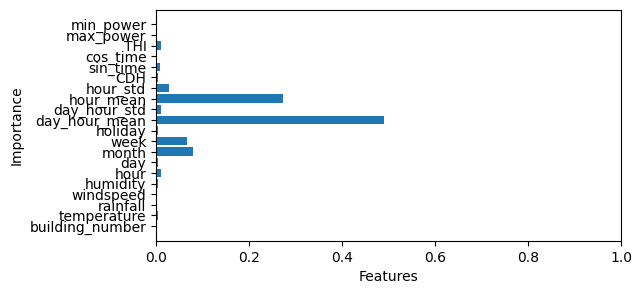

  1%|          | 1/100 [00:03<06:00,  3.64s/it]

SMAPE: 9.23171104485805


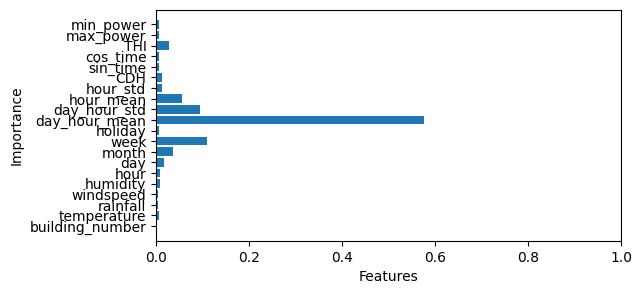

  2%|▏         | 2/100 [00:05<04:04,  2.49s/it]

SMAPE: 18.232372768568595


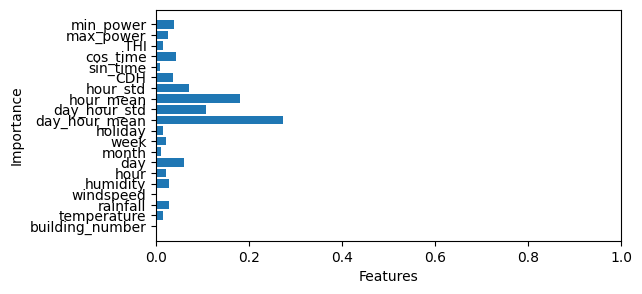

  3%|▎         | 3/100 [00:07<04:03,  2.51s/it]

SMAPE: 7.720129271346675


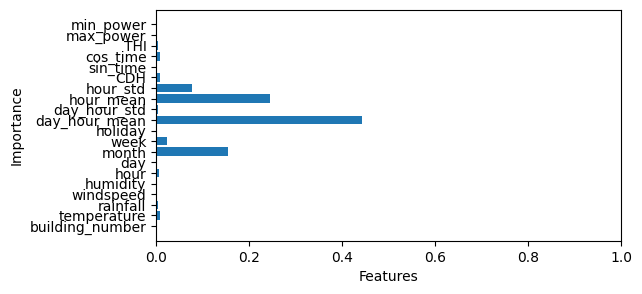

  4%|▍         | 4/100 [00:12<05:13,  3.27s/it]

SMAPE: 8.342475363498497


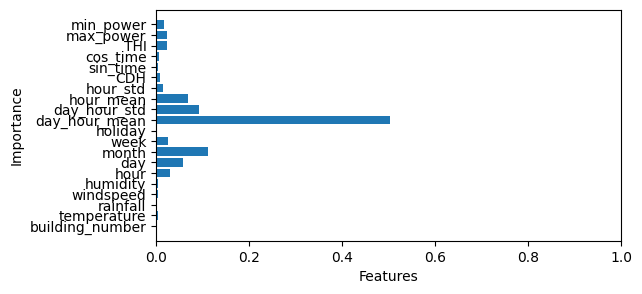

  5%|▌         | 5/100 [00:14<04:24,  2.78s/it]

SMAPE: 5.365727126825137


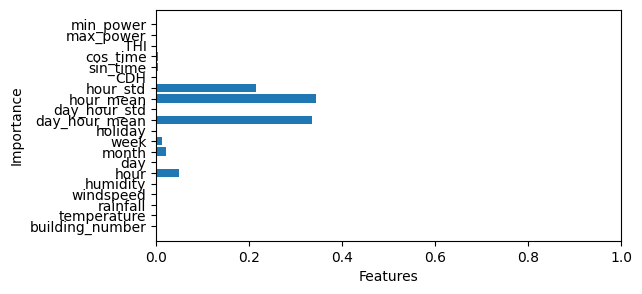

  6%|▌         | 6/100 [00:18<04:57,  3.17s/it]

SMAPE: 8.81227986906209


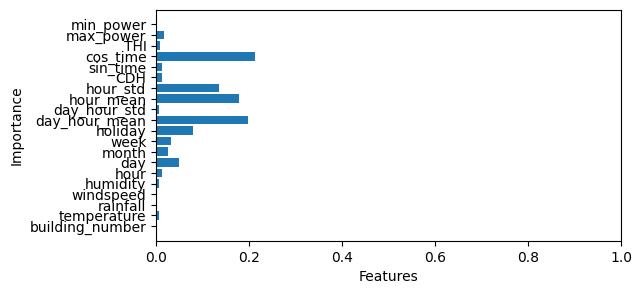

  7%|▋         | 7/100 [00:20<04:27,  2.87s/it]

SMAPE: 5.341445041309718


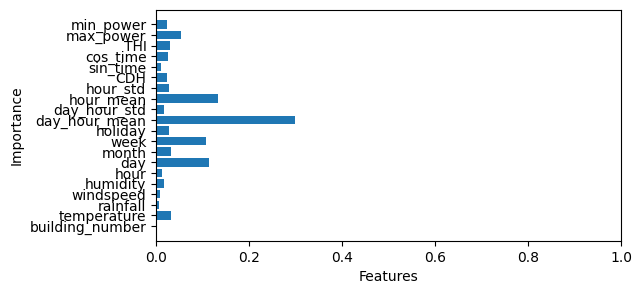

  8%|▊         | 8/100 [00:24<04:58,  3.24s/it]

SMAPE: 2.8685665358242156


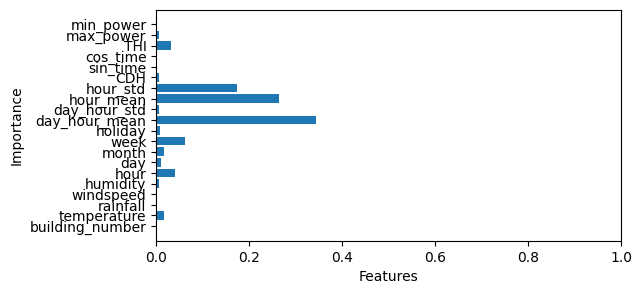

  9%|▉         | 9/100 [00:27<04:52,  3.21s/it]

SMAPE: 10.035185637337365


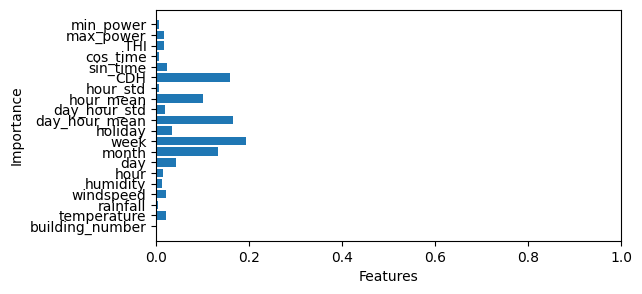

 10%|█         | 10/100 [00:30<04:54,  3.27s/it]

SMAPE: 3.361204074789815


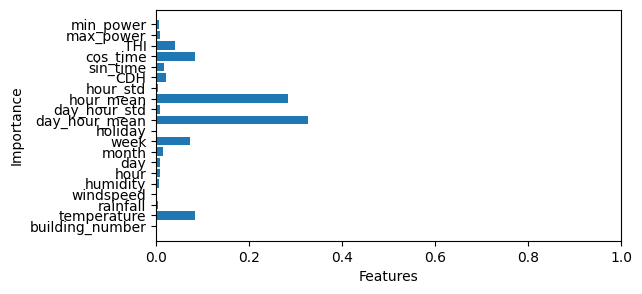

 11%|█         | 11/100 [00:33<04:33,  3.08s/it]

SMAPE: 5.221089612861097


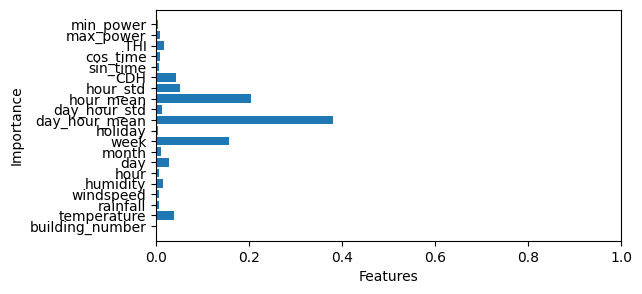

 12%|█▏        | 12/100 [00:36<04:32,  3.09s/it]

SMAPE: 6.973328450065621


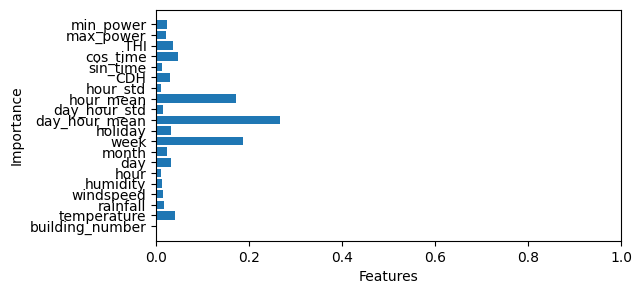

 13%|█▎        | 13/100 [00:41<05:08,  3.55s/it]

SMAPE: 18.213132750042853


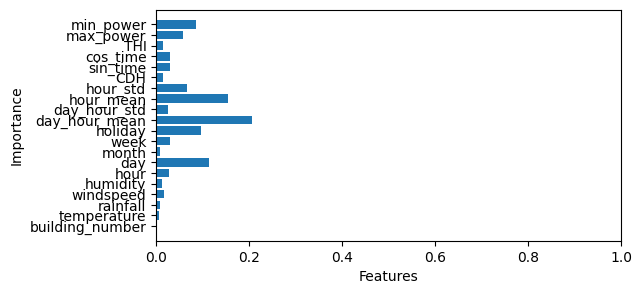

 14%|█▍        | 14/100 [00:43<04:41,  3.28s/it]

SMAPE: 4.422329408635656


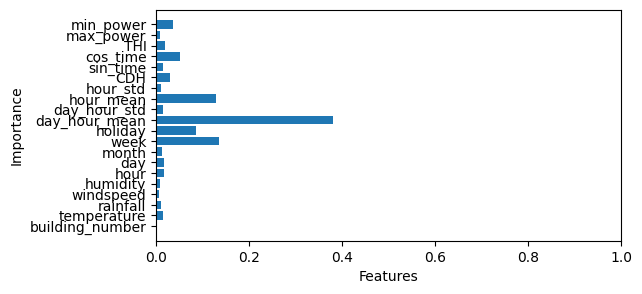

 15%|█▌        | 15/100 [00:46<04:29,  3.17s/it]

SMAPE: 4.886065087878904


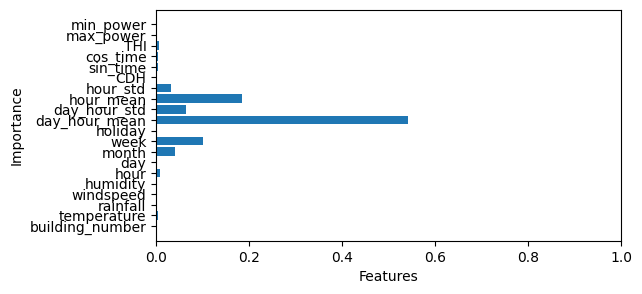

 16%|█▌        | 16/100 [00:51<05:04,  3.62s/it]

SMAPE: 9.42793576035926


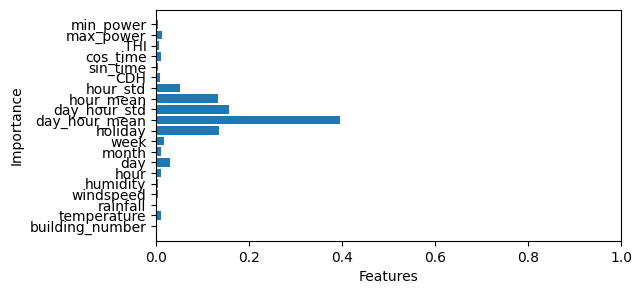

 17%|█▋        | 17/100 [00:52<03:57,  2.86s/it]

SMAPE: 12.478366664953754


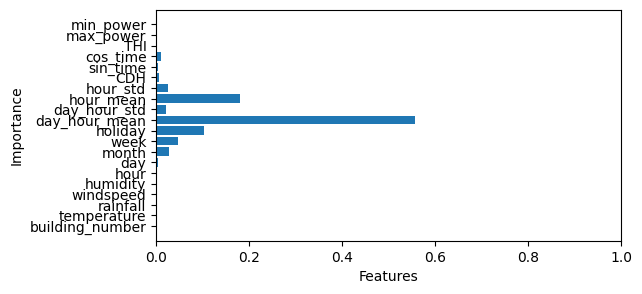

 18%|█▊        | 18/100 [00:55<03:49,  2.79s/it]

SMAPE: 15.256974838238339


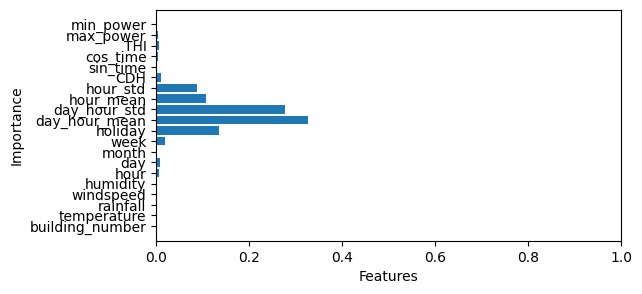

 19%|█▉        | 19/100 [00:56<03:02,  2.25s/it]

SMAPE: 8.374851698063432


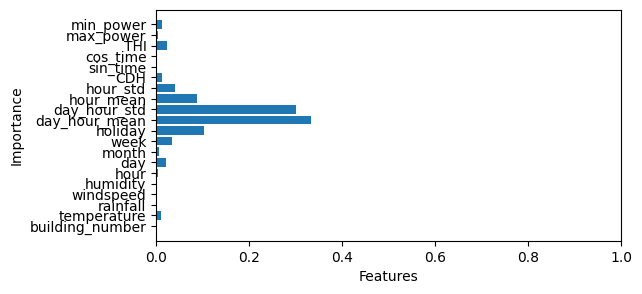

 20%|██        | 20/100 [00:58<02:58,  2.24s/it]

SMAPE: 7.973988465115238


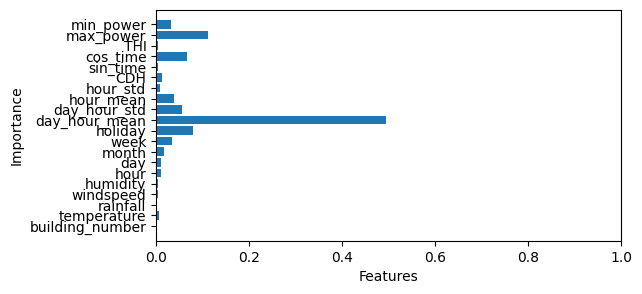

 21%|██        | 21/100 [01:01<03:11,  2.43s/it]

SMAPE: 3.9985387991871266


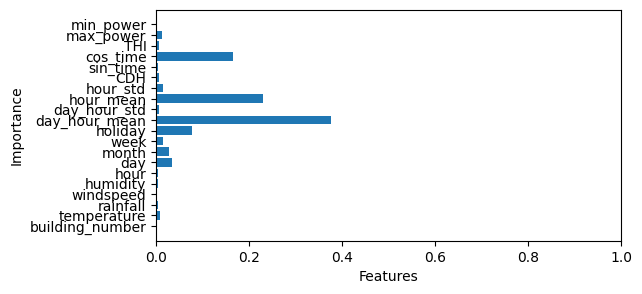

 22%|██▏       | 22/100 [01:04<03:21,  2.59s/it]

SMAPE: 4.353773119109034


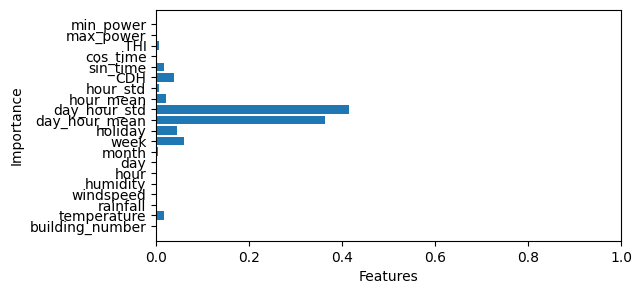

 23%|██▎       | 23/100 [01:06<03:16,  2.55s/it]

SMAPE: 6.560446072607335


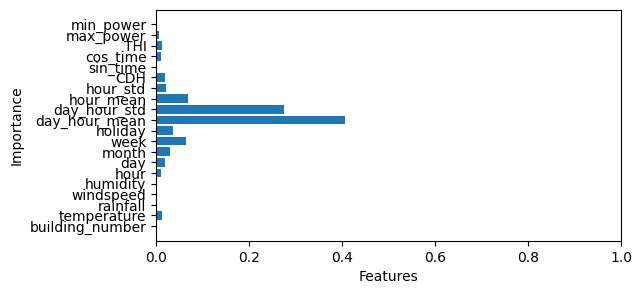

 24%|██▍       | 24/100 [01:07<02:42,  2.13s/it]

SMAPE: 4.756912470969618


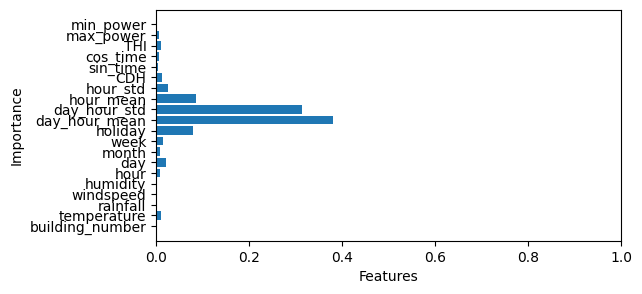

 25%|██▌       | 25/100 [01:10<02:51,  2.29s/it]

SMAPE: 5.729008581792276


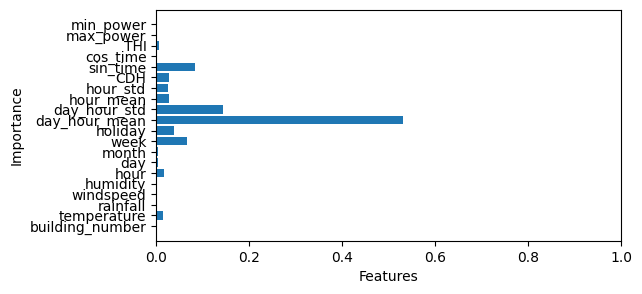

 26%|██▌       | 26/100 [01:13<02:54,  2.36s/it]

SMAPE: 3.8018602613142045


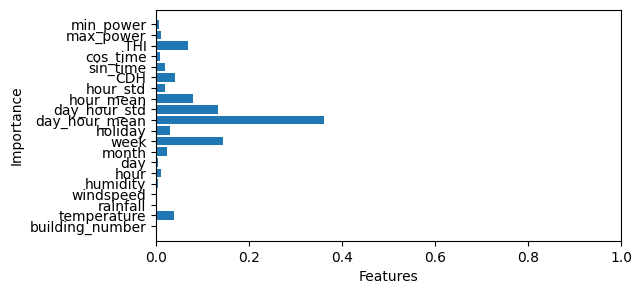

 27%|██▋       | 27/100 [01:15<02:52,  2.37s/it]

SMAPE: 3.9309279212811488


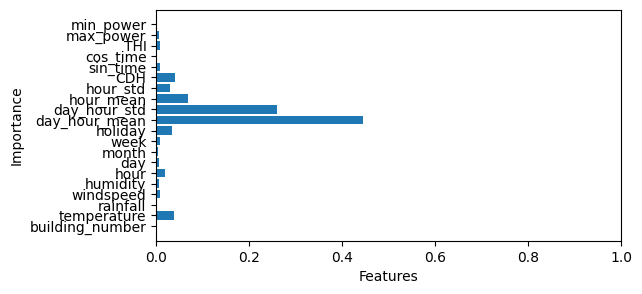

 28%|██▊       | 28/100 [01:17<02:50,  2.37s/it]

SMAPE: 8.963801447621858


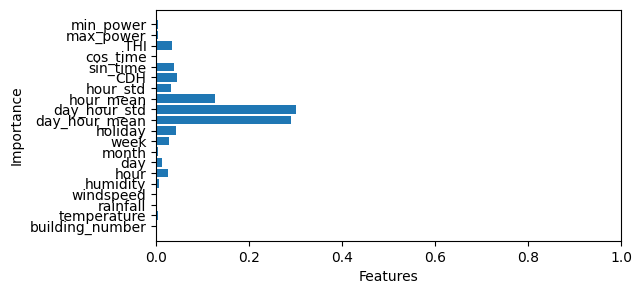

 29%|██▉       | 29/100 [01:18<02:19,  1.97s/it]

SMAPE: 11.274185085307


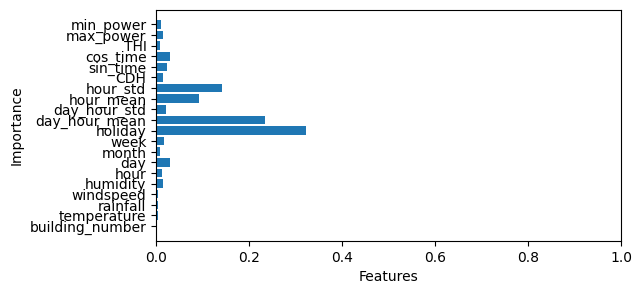

 30%|███       | 30/100 [01:21<02:32,  2.18s/it]

SMAPE: 5.2880101663361065


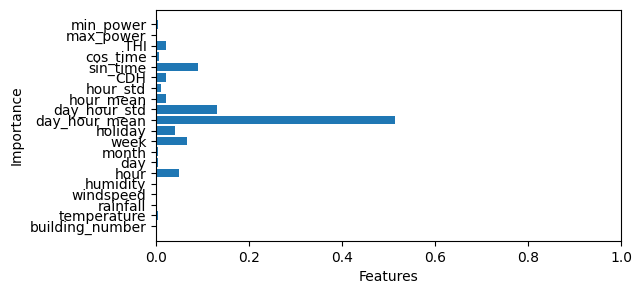

 31%|███       | 31/100 [01:23<02:32,  2.21s/it]

SMAPE: 0.6051011532876539


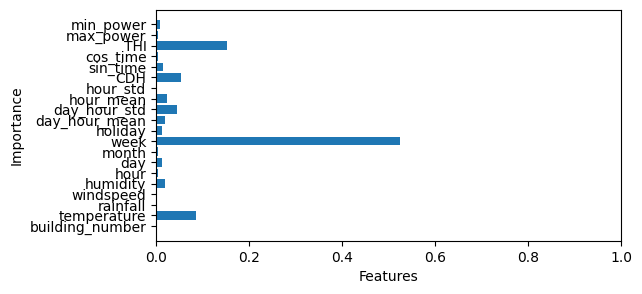

 32%|███▏      | 32/100 [01:27<03:03,  2.70s/it]

SMAPE: 0.3909758791073785


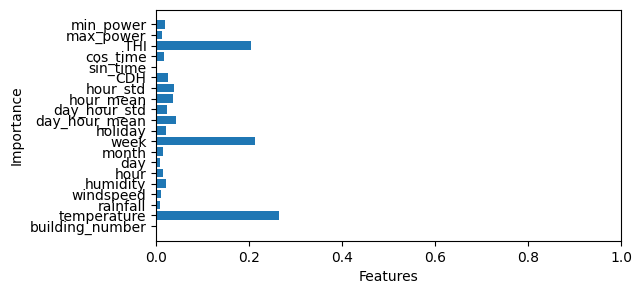

 33%|███▎      | 33/100 [01:29<02:40,  2.40s/it]

SMAPE: 0.8648034748988486


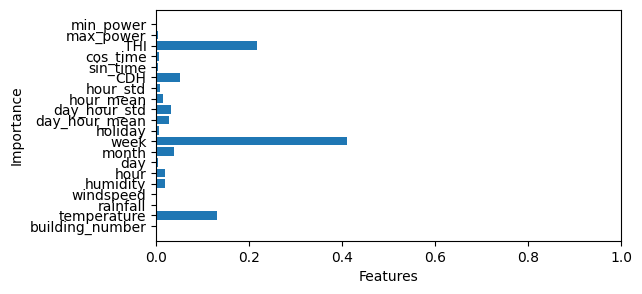

 34%|███▍      | 34/100 [01:33<03:04,  2.80s/it]

SMAPE: 0.6448187508426139


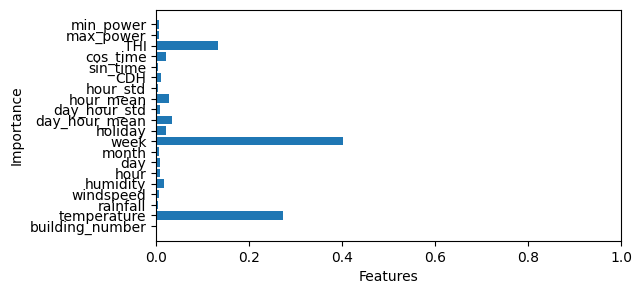

 35%|███▌      | 35/100 [01:37<03:26,  3.18s/it]

SMAPE: 0.40337741381197983


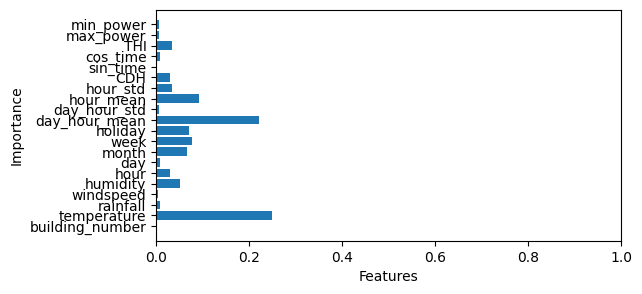

 36%|███▌      | 36/100 [01:44<04:40,  4.39s/it]

SMAPE: 3.636479855831414


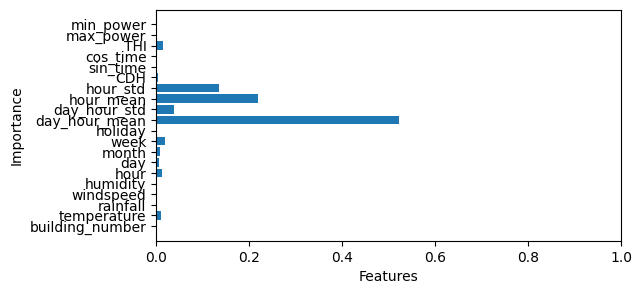

 37%|███▋      | 37/100 [01:47<04:09,  3.96s/it]

SMAPE: 4.522756097350226


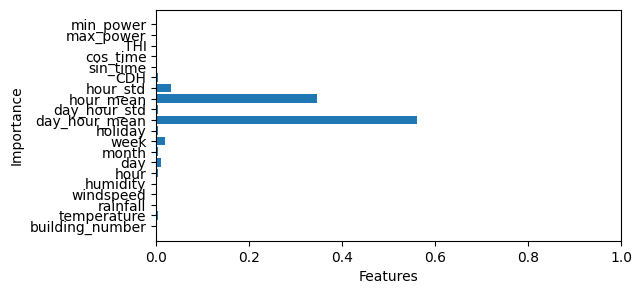

 38%|███▊      | 38/100 [01:54<05:06,  4.95s/it]

SMAPE: 4.607515419007301


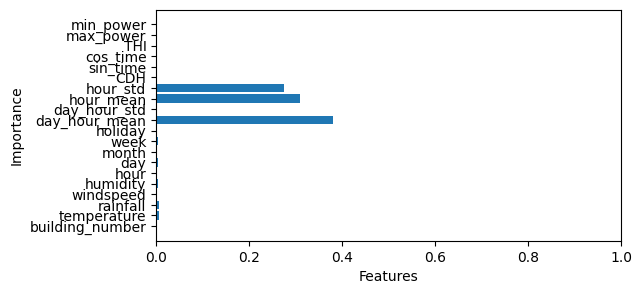

 39%|███▉      | 39/100 [01:59<04:57,  4.88s/it]

SMAPE: 8.586454044132493


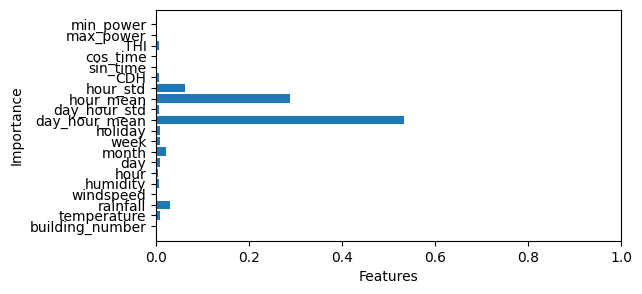

 40%|████      | 40/100 [02:02<04:26,  4.44s/it]

SMAPE: 4.034506634467209


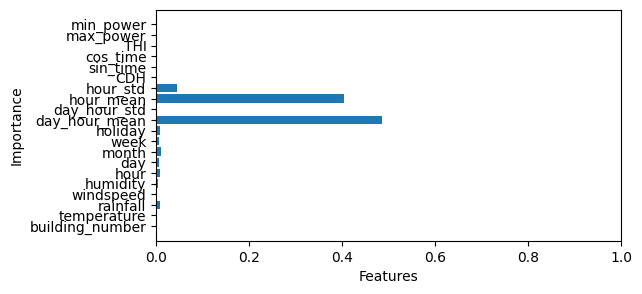

 41%|████      | 41/100 [02:07<04:18,  4.39s/it]

SMAPE: 11.041128393064534


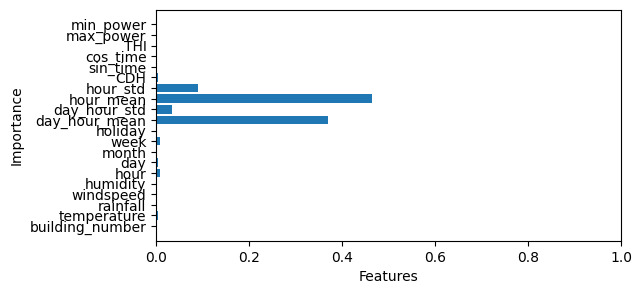

 42%|████▏     | 42/100 [02:12<04:32,  4.69s/it]

SMAPE: 5.575315529701851


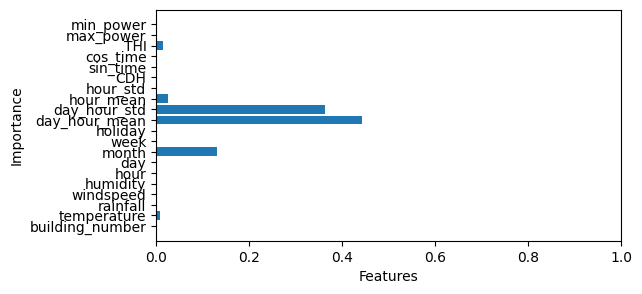

 43%|████▎     | 43/100 [02:16<04:09,  4.38s/it]

SMAPE: 4.0447462068906


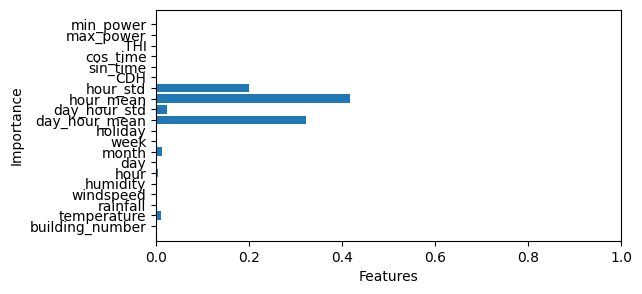

 44%|████▍     | 44/100 [02:19<03:55,  4.20s/it]

SMAPE: 2.201814585578691


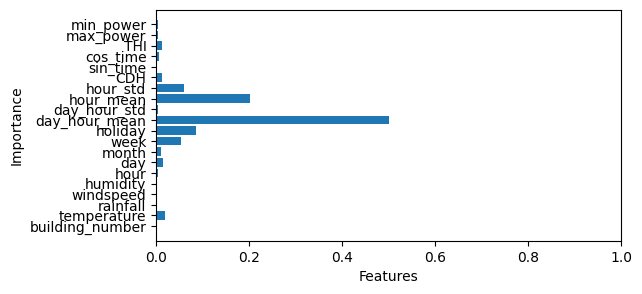

 45%|████▌     | 45/100 [02:24<03:51,  4.22s/it]

SMAPE: 6.219964794386029


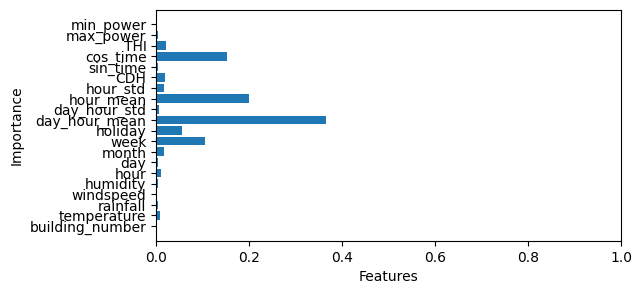

 46%|████▌     | 46/100 [02:26<03:25,  3.81s/it]

SMAPE: 5.96587228719592


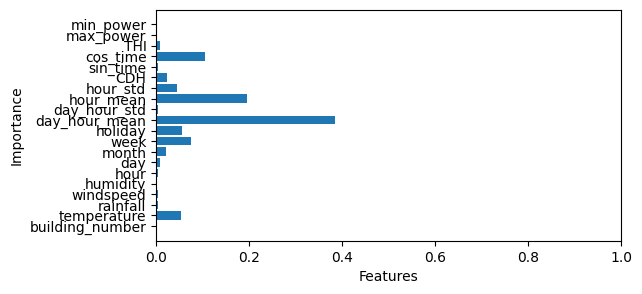

 47%|████▋     | 47/100 [02:28<02:38,  2.98s/it]

SMAPE: 3.144427474115913


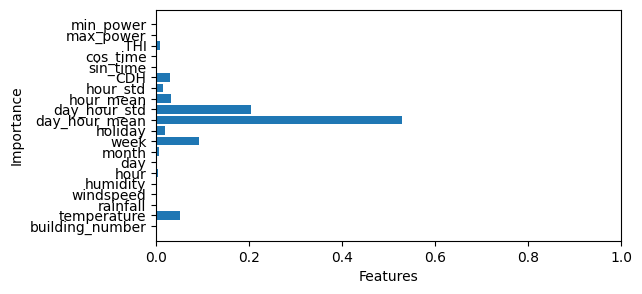

 48%|████▊     | 48/100 [02:29<02:12,  2.55s/it]

SMAPE: 2.4551496808565925


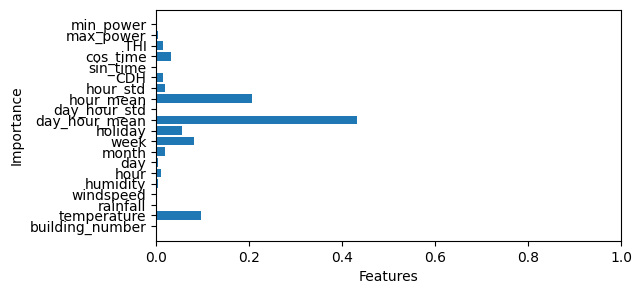

 49%|████▉     | 49/100 [02:34<02:49,  3.31s/it]

SMAPE: 1.6646653947247012


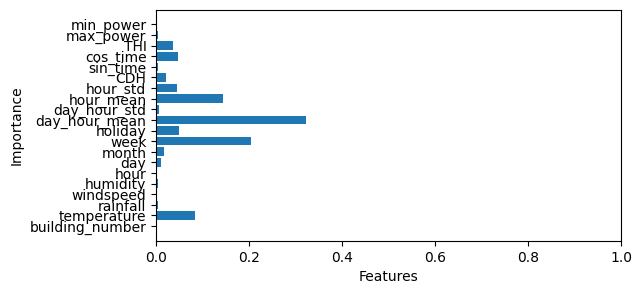

 50%|█████     | 50/100 [02:37<02:44,  3.28s/it]

SMAPE: 6.243353280390039


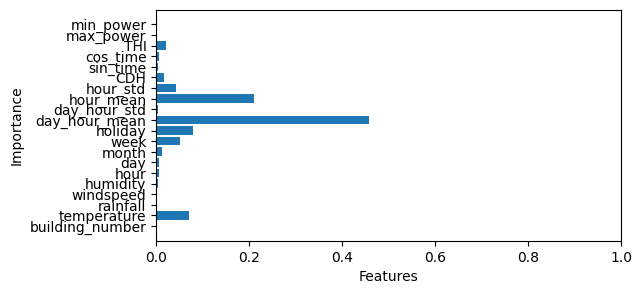

 51%|█████     | 51/100 [02:41<02:39,  3.26s/it]

SMAPE: 3.9180278868210356


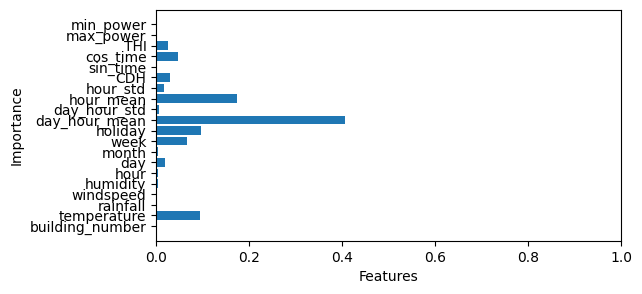

 52%|█████▏    | 52/100 [02:44<02:35,  3.24s/it]

SMAPE: 13.41686968921113


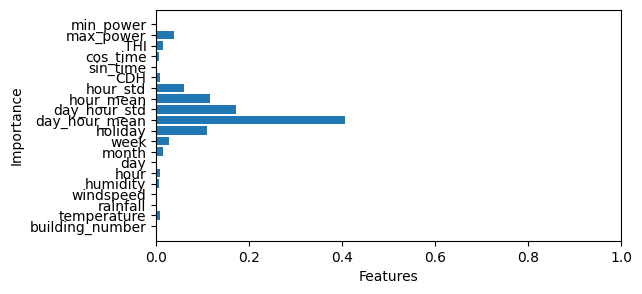

 53%|█████▎    | 53/100 [02:46<02:13,  2.83s/it]

SMAPE: 38.16543788437001


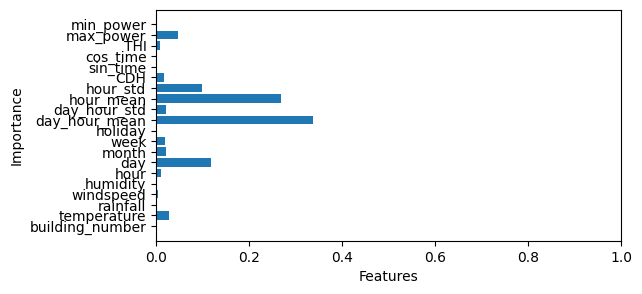

 54%|█████▍    | 54/100 [02:47<01:52,  2.44s/it]

SMAPE: 1.9713720238274541


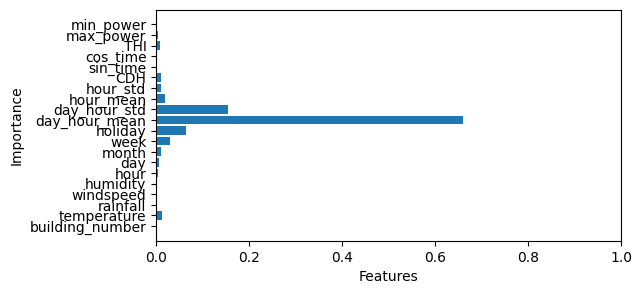

 55%|█████▌    | 55/100 [02:48<01:33,  2.09s/it]

SMAPE: 0.8332671199957135


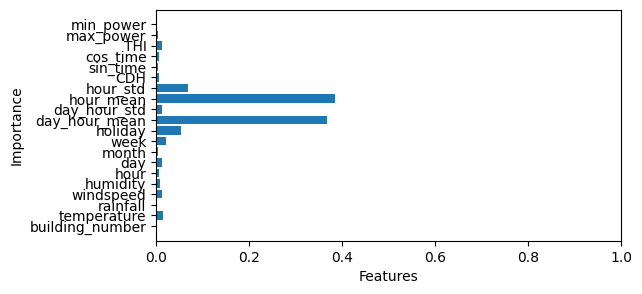

 56%|█████▌    | 56/100 [02:52<01:53,  2.58s/it]

SMAPE: 5.007470046196626


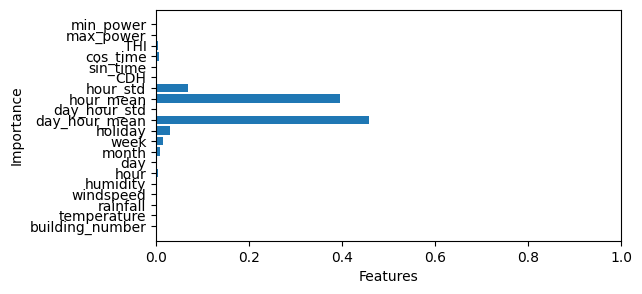

 57%|█████▋    | 57/100 [02:54<01:41,  2.37s/it]

SMAPE: 0.5298574177755


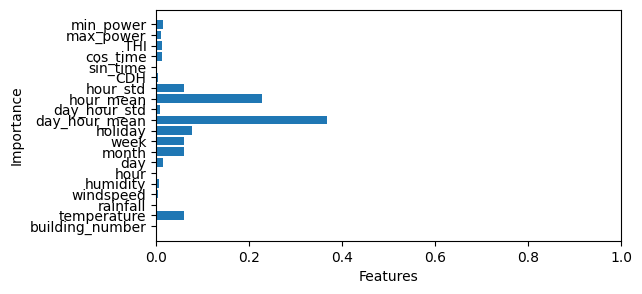

 58%|█████▊    | 58/100 [02:58<02:02,  2.92s/it]

SMAPE: 5.61172126255406


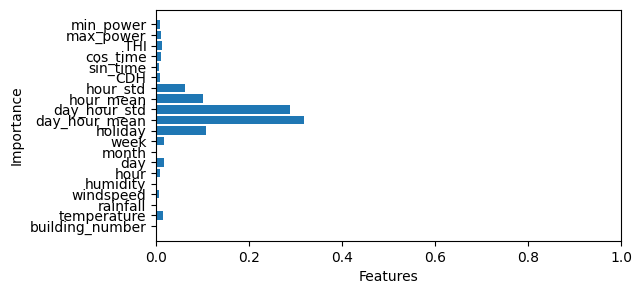

 59%|█████▉    | 59/100 [02:59<01:38,  2.40s/it]

SMAPE: 5.914908811444821


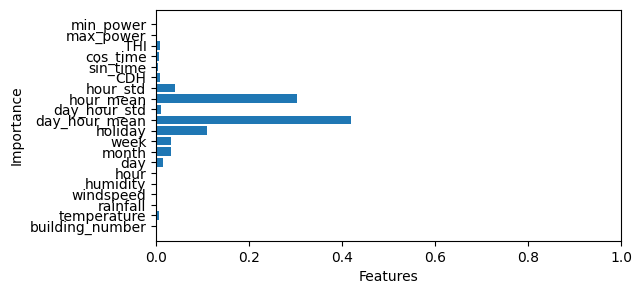

 60%|██████    | 60/100 [03:03<01:52,  2.82s/it]

SMAPE: 4.154032320722491


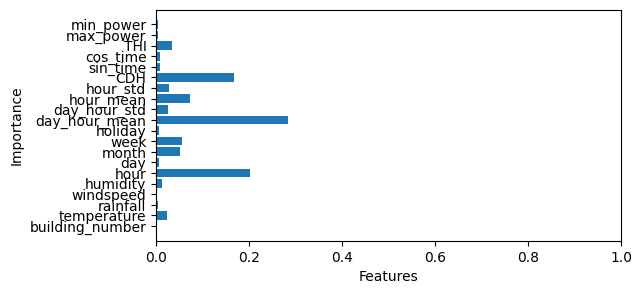

 61%|██████    | 61/100 [03:06<01:54,  2.94s/it]

SMAPE: 4.6477503357892305


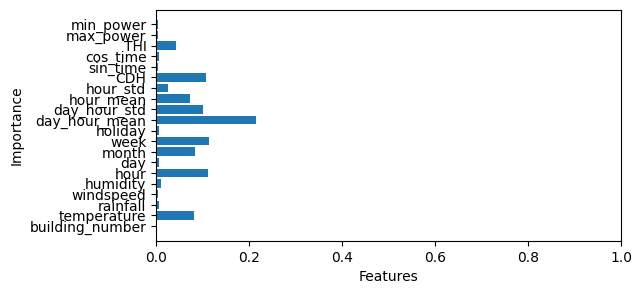

 62%|██████▏   | 62/100 [03:09<01:51,  2.93s/it]

SMAPE: 6.466118322413251


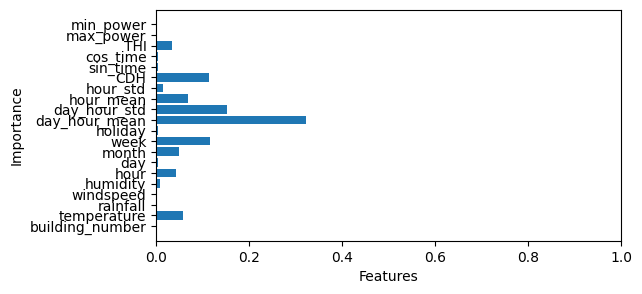

 63%|██████▎   | 63/100 [03:11<01:38,  2.65s/it]

SMAPE: 4.3726876488303015


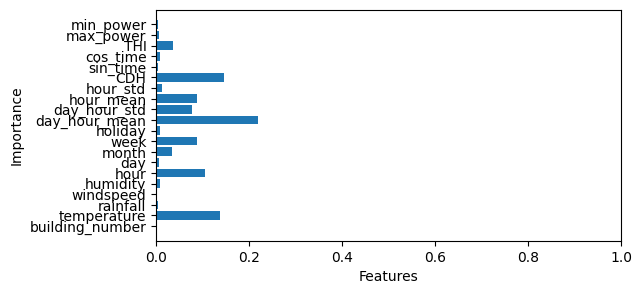

 64%|██████▍   | 64/100 [03:15<01:43,  2.88s/it]

SMAPE: 11.290237513444708


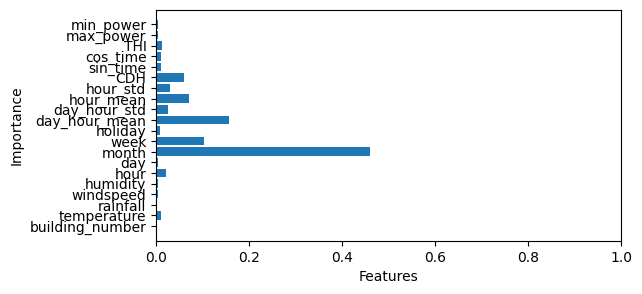

 65%|██████▌   | 65/100 [03:22<02:27,  4.23s/it]

SMAPE: 3.550279564125387


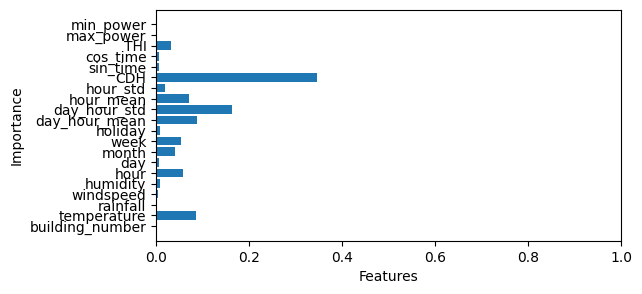

 66%|██████▌   | 66/100 [03:26<02:22,  4.20s/it]

SMAPE: 4.934141427574303


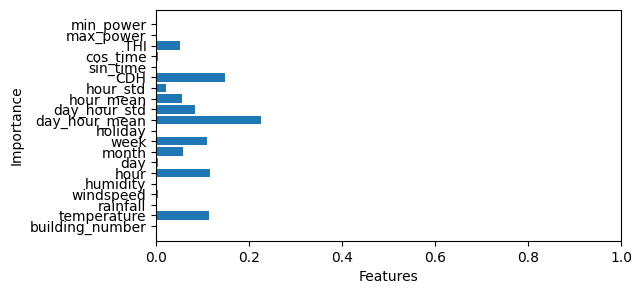

 67%|██████▋   | 67/100 [03:28<01:53,  3.45s/it]

SMAPE: 3.5231543543489257


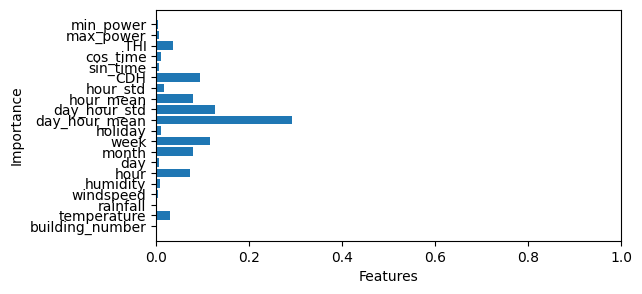

 68%|██████▊   | 68/100 [03:32<01:52,  3.51s/it]

SMAPE: 4.352441782720291


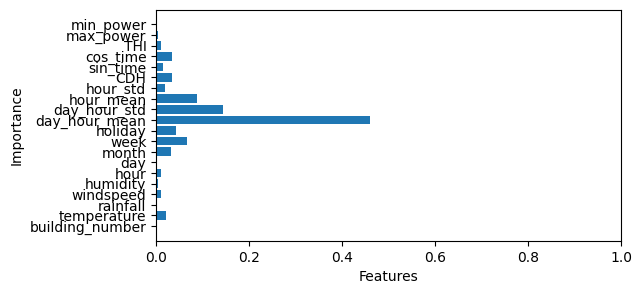

 69%|██████▉   | 69/100 [03:34<01:41,  3.28s/it]

SMAPE: 2.3014997549960663


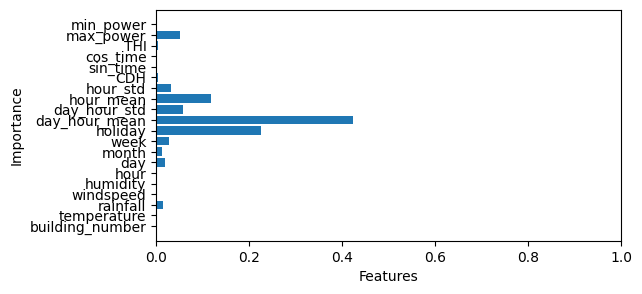

 70%|███████   | 70/100 [03:39<01:48,  3.63s/it]

SMAPE: 6.569343239490152


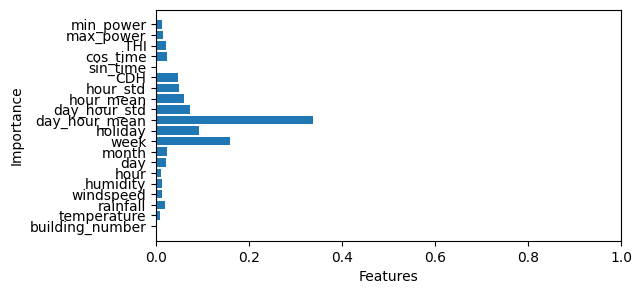

 71%|███████   | 71/100 [03:42<01:39,  3.43s/it]

SMAPE: 9.869948876067735


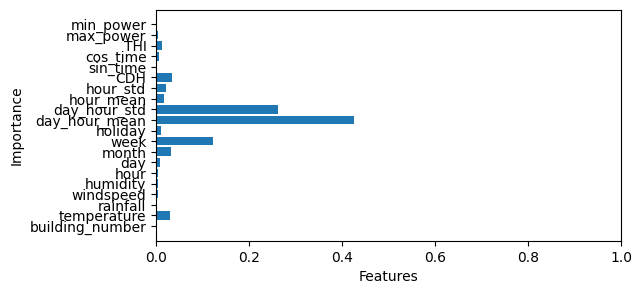

 72%|███████▏  | 72/100 [03:43<01:16,  2.74s/it]

SMAPE: 3.097073711631112


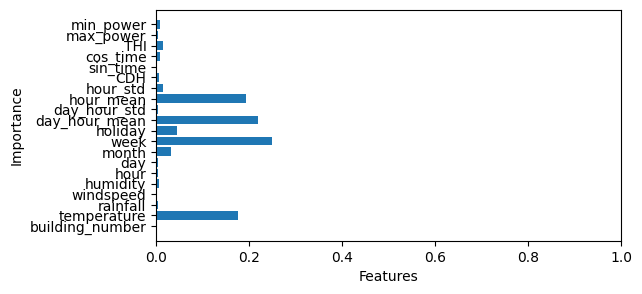

 73%|███████▎  | 73/100 [03:45<01:07,  2.51s/it]

SMAPE: 5.467738482706381


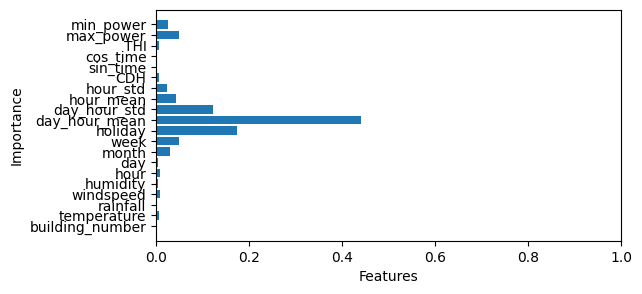

 74%|███████▍  | 74/100 [03:48<01:07,  2.61s/it]

SMAPE: 4.4400142920234416


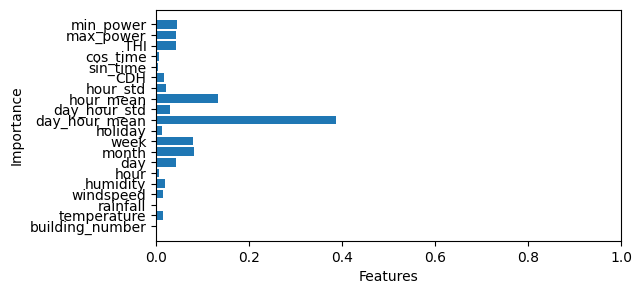

 75%|███████▌  | 75/100 [03:52<01:17,  3.10s/it]

SMAPE: 5.253177577615364


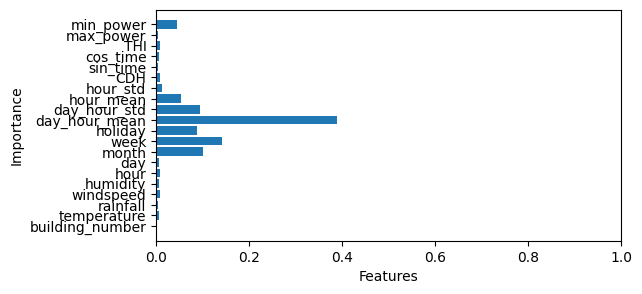

 76%|███████▌  | 76/100 [03:56<01:18,  3.25s/it]

SMAPE: 2.9055306203702997


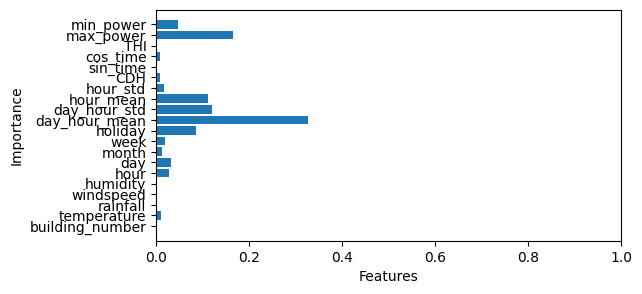

 77%|███████▋  | 77/100 [03:59<01:15,  3.26s/it]

SMAPE: 6.813146006377851


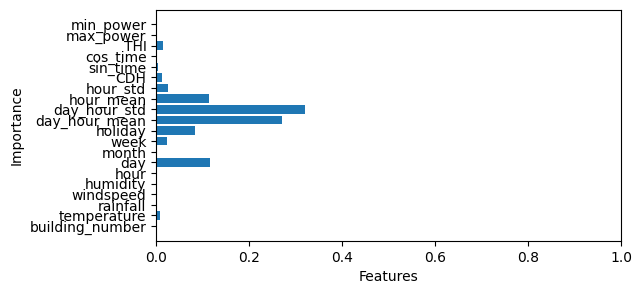

 78%|███████▊  | 78/100 [04:02<01:07,  3.07s/it]

SMAPE: 6.113752953409629


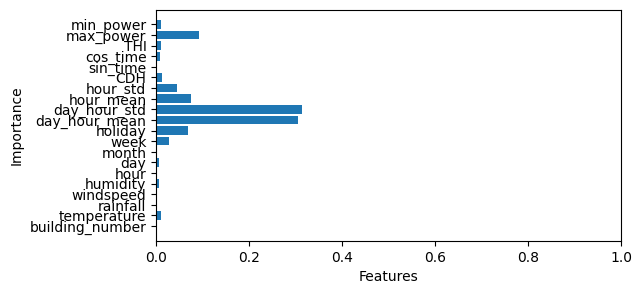

 79%|███████▉  | 79/100 [04:03<00:51,  2.47s/it]

SMAPE: 15.038485911277581


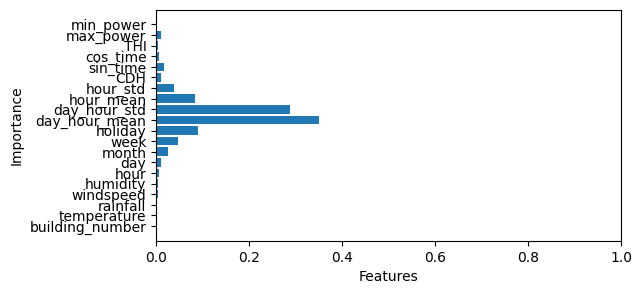

 80%|████████  | 80/100 [04:05<00:50,  2.51s/it]

SMAPE: 3.604126642525204


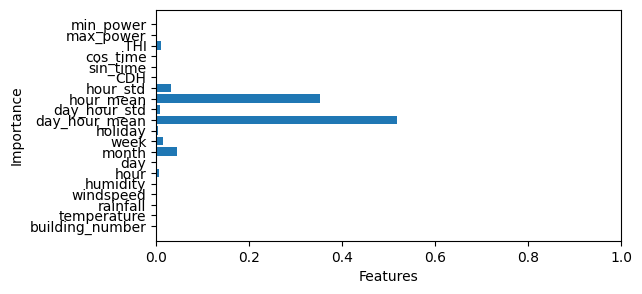

 81%|████████  | 81/100 [04:11<01:06,  3.48s/it]

SMAPE: 12.587745686971752


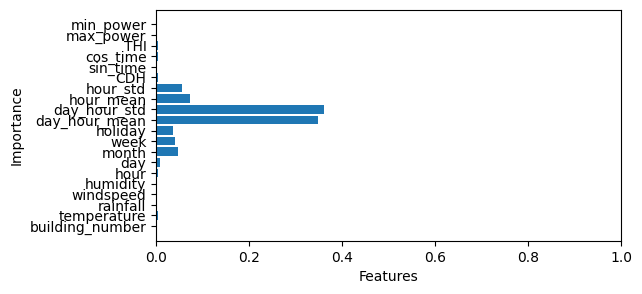

 82%|████████▏ | 82/100 [04:12<00:50,  2.81s/it]

SMAPE: 12.662180758543773


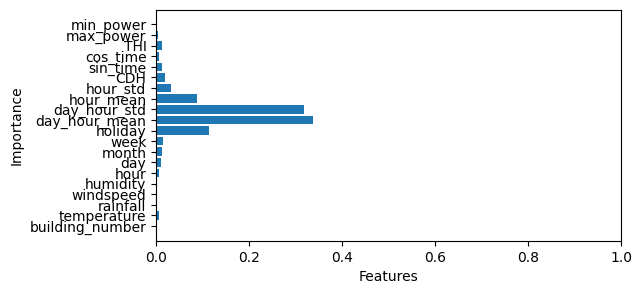

 83%|████████▎ | 83/100 [04:13<00:38,  2.29s/it]

SMAPE: 9.263466371741405


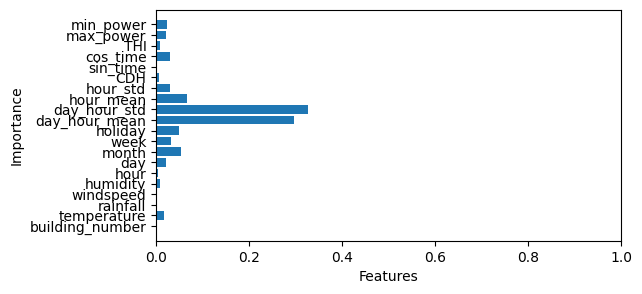

 84%|████████▍ | 84/100 [04:16<00:36,  2.30s/it]

SMAPE: 3.5176146197123064


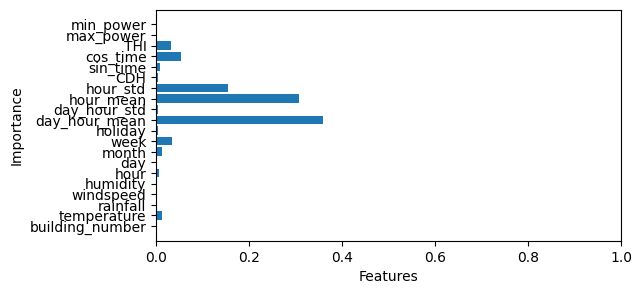

 85%|████████▌ | 85/100 [04:20<00:45,  3.02s/it]

SMAPE: 4.436292551714161


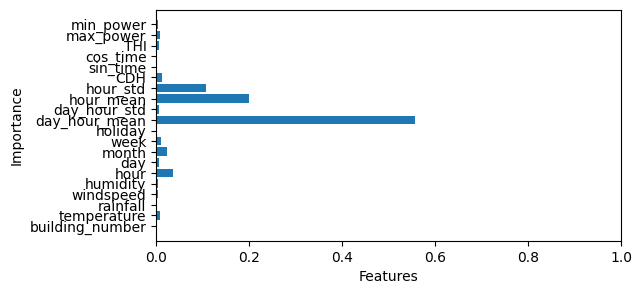

 86%|████████▌ | 86/100 [04:24<00:45,  3.23s/it]

SMAPE: 10.068359577249973


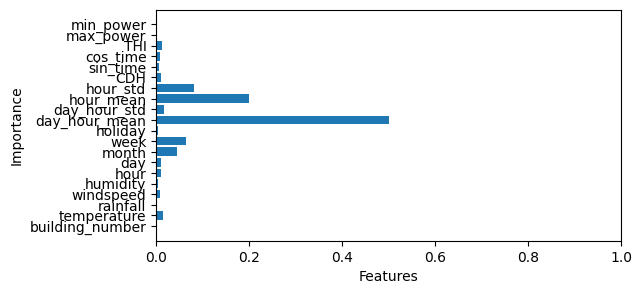

 87%|████████▋ | 87/100 [04:27<00:40,  3.09s/it]

SMAPE: 17.21052751499732


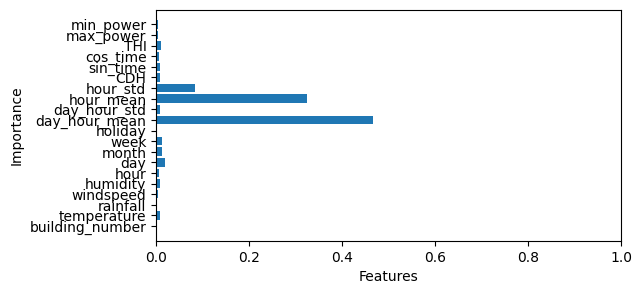

 88%|████████▊ | 88/100 [04:28<00:31,  2.59s/it]

SMAPE: 15.01642890334506


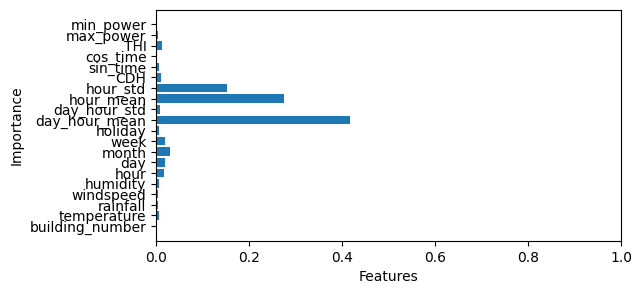

 89%|████████▉ | 89/100 [04:30<00:24,  2.25s/it]

SMAPE: 12.058690884859102


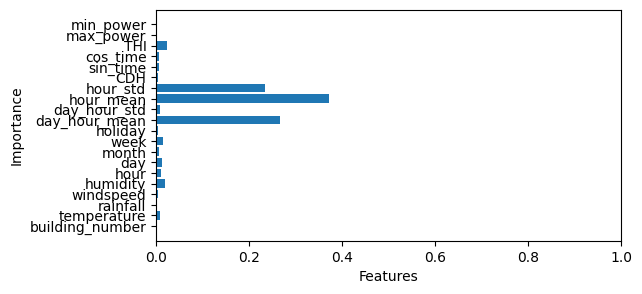

 90%|█████████ | 90/100 [04:32<00:23,  2.33s/it]

SMAPE: 13.454070110446718


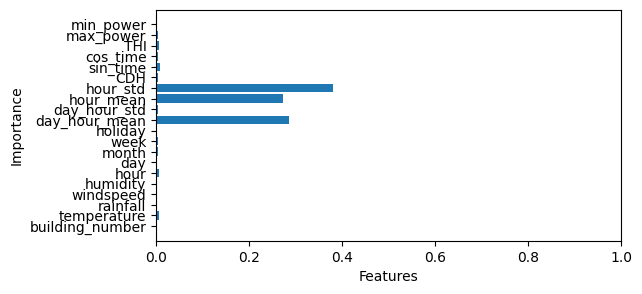

 91%|█████████ | 91/100 [04:35<00:22,  2.47s/it]

SMAPE: 12.325043478387613


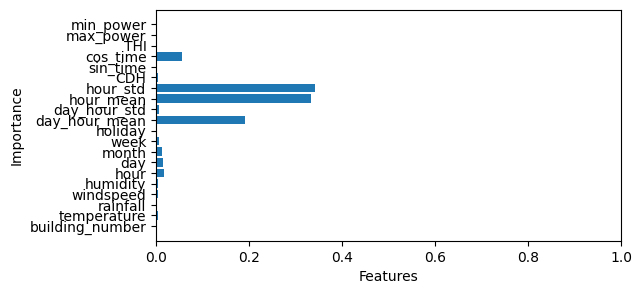

 92%|█████████▏| 92/100 [04:37<00:19,  2.39s/it]

SMAPE: 7.158810196099082


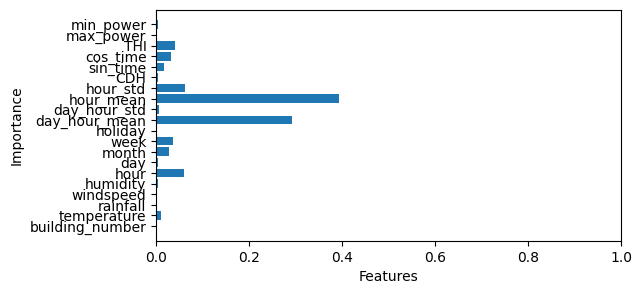

 93%|█████████▎| 93/100 [04:41<00:20,  2.91s/it]

SMAPE: 6.583651646615306


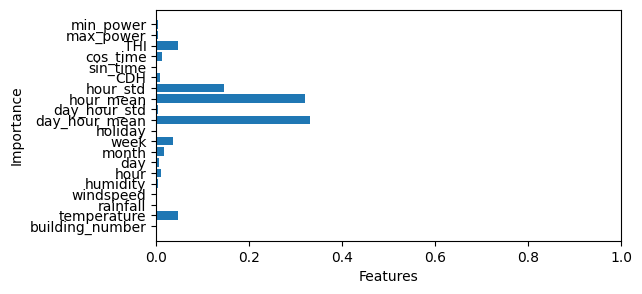

 94%|█████████▍| 94/100 [04:45<00:19,  3.29s/it]

SMAPE: 16.843544678942163


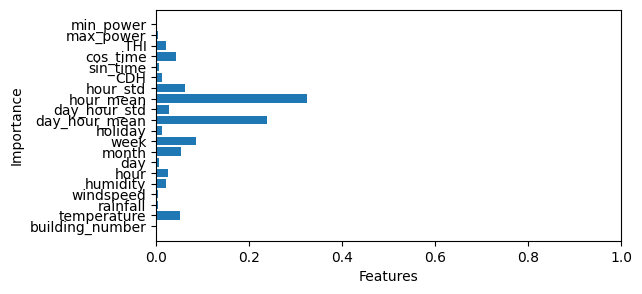

 95%|█████████▌| 95/100 [04:48<00:15,  3.03s/it]

SMAPE: 2.9652217109894043


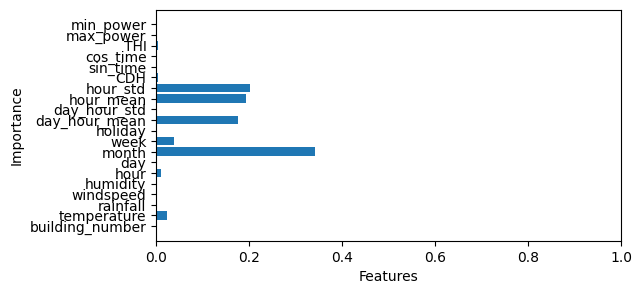

 96%|█████████▌| 96/100 [04:50<00:10,  2.64s/it]

SMAPE: 5.134333214125172


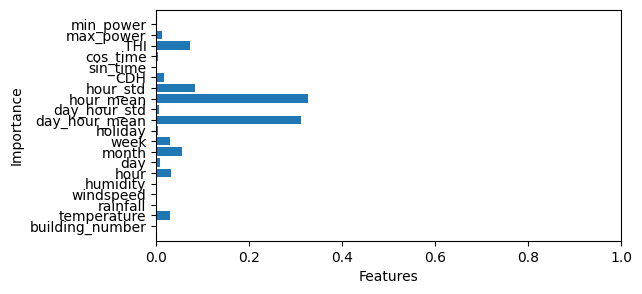

 97%|█████████▋| 97/100 [04:56<00:11,  3.86s/it]

SMAPE: 12.377377863051887


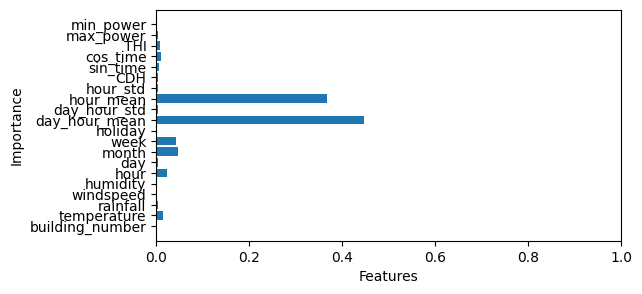

 98%|█████████▊| 98/100 [04:59<00:06,  3.46s/it]

SMAPE: 3.217447452956124


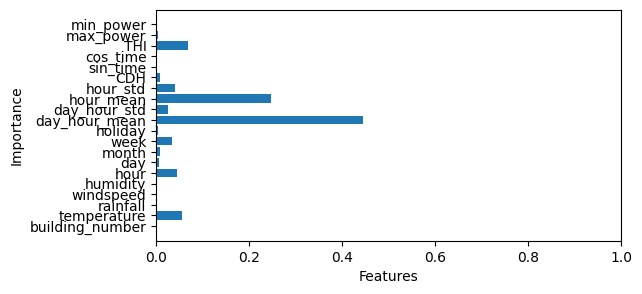

 99%|█████████▉| 99/100 [05:01<00:02,  2.94s/it]

SMAPE: 5.174639036244805


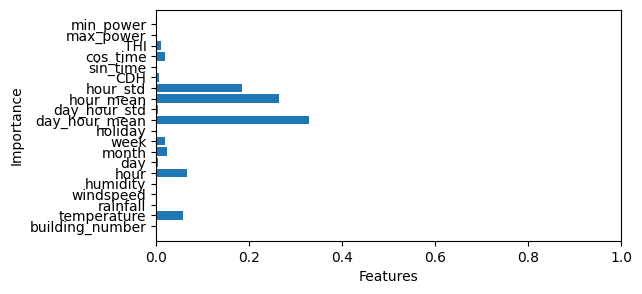

100%|██████████| 100/100 [05:05<00:00,  3.05s/it]


In [4]:
#smape점수 산출용
preds = np.array([])
smapes = []
missfit_building = []
hyper = pd.read_csv(f'./parameters/hyperparameter_xgb_wsw0808-1540.csv').drop(columns=['Unnamed: 0'])
for i in tqdm(range(100)):
    train_df = pd.read_csv(f'./pretest/train_building{i+1}.csv').drop(columns=['Unnamed: 0'])
    pretest_df = pd.read_csv(f'./pretest/pretest_building{i+1}.csv').drop(columns=['Unnamed: 0'])
    pred_df = pd.DataFrame()   # pretest 예측값을 담을 data frame
    
    feature_importances = []
    for seed in [0,1,2,3,4,5]: # 각 시드별 예측
        y_train = train_df['power_consumption']
        x_train = train_df.drop(columns=['power_consumption'])
        
        x_pretest = pretest_df.drop(columns=['power_consumption'])
        y_pretest = pretest_df['power_consumption']
        
        xgb = XGBRegressor(seed = seed, tree_method="hist", gpu_id=0,          
                           n_estimators = hyper.iloc[i,6], 
                           eta = hyper.iloc[i, 1],
                           min_child_weight = hyper.iloc[i, 2], max_depth = hyper.iloc[i, 3],
                           colsample_bytree=hyper.iloc[i, 4], subsample=hyper.iloc[i, 5])

        if hyper.iloc[i, 7] != 0:  # 만약 alpha가 0이 아니면 weighted_mse 사용
            xgb.set_params(**{'objective':weighted_mse(hyper.iloc[i,7])})

        xgb.fit(x_train, y_train)
        feature_importances.append(xgb.feature_importances_)
        y_pred = xgb.predict(x_pretest)
        pred_df.loc[:,seed] = y_pred   # 각 시드별 예측 담기
    
    pred = pred_df.mean(axis=1)   # (i+1)번째 건물의 예측 =  (i+1)번째 건물의 각 시드별 예측 평균값
    pred_np = pred.to_numpy()
    y_pretest_np = y_pretest.to_numpy()
    score = SMAPE(y_pretest_np,pred_np) 
    preds = np.append(preds, pred)
    print("SMAPE:",score)
    average_feature_importances = np.mean(feature_importances, axis=0)
    plt.subplots(figsize=(6, 3))
    plt.barh(x_train.columns, average_feature_importances)
    plt.xlabel('Features')
    plt.xlim(0,1)
    plt.ylabel('Importance')
    plt.show()
    smapes.append(score)
    
    if score > 6:
        missfit_building.append(i)

In [4]:
print(np.mean(smapes))

6.903537293811309
